In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pycaret
import argparse
import os
import warnings
warnings.filterwarnings("ignore")

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, StratifiedKFold, StratifiedShuffleSplit
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import plot_tree
import graphviz 
import shap

# 1. DATA COLLECTION

In [2]:
# Load files ADRC, B5, B6, B7, B9 and D1
df = pd.read_csv('adrc_b5_b6_b7_b9_d1.csv')
df.head()

,id,Label,Subject,Date,Gender,Age,mmse,ageAtEntry,cdr,commun,...,NEOPIF,COGOTH,COGOTHX,COGOTHIF,COGOTH2,COGOTH2X,COGOTH2F,COGOTH3,COGOTH3X,COGOTH3F
0,/@WEBAPP/images/r.gif,OAS30124_ClinicalData_d0341,OAS30124,NaN,female,NaN,16.0,79.14579,1.0,1.0,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/@WEBAPP/images/r.gif,OAS30354_ClinicalData_d1147,OAS30354,NaN,male,NaN,29.0,66.64203,2.0,2.0,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
2,/@WEBAPP/images/r.gif,OAS31129_ClinicalData_d1138,OAS31129,NaN,female,NaN,20.0,68.07666,1.0,1.0,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
3,/@WEBAPP/images/r.gif,OAS30813_ClinicalData_d0000,OAS30813,NaN,female,NaN,30.0,70.55441,0.0,0.0,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN
4,/@WEBAPP/images/r.gif,OAS30184_ClinicalData_d2721,OAS30184,NaN,female,NaN,30.0,73.07597,0.0,0.0,...,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN


In [3]:
# Function that drop the null columns 
def delete(df):
    a = df.isnull().sum() # Count the null values for each column
    null = a[a==df.shape[0]].index # Print only the columns which have no any value 
    df1 = df.drop(null, axis = 1) # Create a new df without the null columns
    return df1

In [4]:
# Drop the columns with null values from clinical data
df1 = delete(df)

In [5]:
# Drop the column id, as we will not use information from photos
df1.drop(['id'], axis = 1, inplace = True)

In [6]:
# Print the shape before and after dropping the columns
print('The shape of the initial dataframe is:', df.shape)
print('The shape after dropping columns is:', df1.shape)

The shape of the initial dataframe is: (6224, 198)
The shape after dropping columns is: (6224, 170)


In [7]:
# Keep only the visit intervals from column 'Label' 
df1['Label'] = df1['Label'].map(lambda x: str(x)[-4:])
df1.rename(columns={'Label': 'Day'}, inplace=True)
#cd1['Visit_intervals'] = cd1.Visit_intervals.astype('int')

In [8]:
# Sort the dataframe by Subject and by Day
df1 = df1.sort_values(['Subject', 'Day'], ascending=[True, True])
df1.head()

,Day,Subject,Gender,mmse,ageAtEntry,cdr,commun,dx1,dx2,dx3,...,BRNINJ,BRNINJIF,NEOP,NEOPIF,COGOTH,COGOTHIF,COGOTH2,COGOTH2F,COGOTH3,COGOTH3F
3091,0000,OAS30001,female,28.0,65.149895,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3581,0339,OAS30001,female,28.0,65.149895,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
5538,0722,OAS30001,female,30.0,65.149895,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
5943,1106,OAS30001,female,30.0,65.149895,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3324,1456,OAS30001,female,30.0,65.149895,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN


In [9]:
# Specify all rows of column dx1 which start with AD and convert these values with AD Dementia 
df1.loc[df1['dx1'].str.startswith('AD', na = False),'dx1'] = 'AD Dementia'  

In [10]:
# Calculating the minimum and the maximum value that each subject id shown 
df1['Subject'].value_counts().agg(['min','max'])

min     1
max    31
Name: Subject, dtype: int64

#### Part of the Dataframe with AD

In [11]:
# Select ids that have had AD Dementia
subject_list = df1.loc[df1['dx1'] == 'AD Dementia', 'Subject'].unique()

# Count the subjects who have shown AD Dementia 
print('The subjects with AD dementia are: {}\n'.format(len(subject_list)))

# Print all subjects who have been diagnosed at least once with AD Dementia
ad = df1[df1['Subject'].isin(subject_list)] # Subset of initial df with subjects who have been diagnosed with AD Dementia at least once
ad.head()

The subjects with AD dementia are: 344



,Day,Subject,Gender,mmse,ageAtEntry,cdr,commun,dx1,dx2,dx3,...,BRNINJ,BRNINJIF,NEOP,NEOPIF,COGOTH,COGOTHIF,COGOTH2,COGOTH2F,COGOTH3,COGOTH3F
5686,0000,OAS30019,female,29.0,74.37919,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
1018,0553,OAS30019,female,24.0,74.37919,0.5,0.5,AD Dementia,Active Mood disorder,Remote Alcoholism,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
284,0977,OAS30019,female,29.0,74.37919,0.5,0.0,AD Dementia,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
4154,0000,OAS30022,male,30.0,74.32443,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2567,0519,OAS30022,male,26.0,74.32443,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [12]:
# Select ids who have been diagnosed at least once with AD Dementia and Cognitively normal
subject_list_cn = ad.loc[ad['dx1'] == 'Cognitively normal', 'Subject'].unique()

# Print the unique value of these subjects
print('The subjects with AD dementia are: {}\n'.format(len(subject_list_cn)))

# Create a new dataframe with subjects who have been diagnosed at least once with AD Dementia and Cognitively normal  
adcn = ad[ad['Subject'].isin(subject_list_cn)] 

adcn = adcn.sort_values(['Subject', 'Day'], ascending=[True, True])
adcn.head()

The subjects with AD dementia are: 130



,Day,Subject,Gender,mmse,ageAtEntry,cdr,commun,dx1,dx2,dx3,...,BRNINJ,BRNINJIF,NEOP,NEOPIF,COGOTH,COGOTHIF,COGOTH2,COGOTH2F,COGOTH3,COGOTH3F
5686,0000,OAS30019,female,29.0,74.37919,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
1018,0553,OAS30019,female,24.0,74.37919,0.5,0.5,AD Dementia,Active Mood disorder,Remote Alcoholism,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
284,0977,OAS30019,female,29.0,74.37919,0.5,0.0,AD Dementia,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
4154,0000,OAS30022,male,30.0,74.32443,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2567,0519,OAS30022,male,26.0,74.32443,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [13]:
# Create a dataframe with subjects who have been diagnosed with AD but not with CN
notadcn = ad[~ad['Subject'].isin(subject_list_cn)]

# Calculate the number of times each subject is appeared
x = notadcn['Subject'].value_counts()

# Calculate the number of unique diagnoses for subjects
y = notadcn.groupby('Subject')['dx1'].apply(lambda x: x.nunique())

# Print
print('Number of unique subjects:{}'.format(len(notadcn.Subject.unique())))
print('There are {} subjects who have only one diagnose, this is AD.'.format(x[x == 1].sum()))
print('The number of unique diagnoses is the following:\n {}\n'.format(y.value_counts()))
notadcn.head()

Number of unique subjects:214
There are 36 subjects who have only one diagnose, this is AD.
The number of unique diagnoses is the following:
 1    163
2     42
3      7
4      2
Name: dx1, dtype: int64



,Day,Subject,Gender,mmse,ageAtEntry,cdr,commun,dx1,dx2,dx3,...,BRNINJ,BRNINJIF,NEOP,NEOPIF,COGOTH,COGOTHIF,COGOTH2,COGOTH2F,COGOTH3,COGOTH3F
5743,0000,OAS30024,female,27.0,76.643394,0.5,0.5,AD Dementia,.,.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5591,0345,OAS30024,female,26.0,76.643394,0.5,0.5,AD Dementia,.,.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2149,0000,OAS30029,male,28.0,72.369610,0.5,0.0,uncertain dementia,Remote Med-induced Cog Dys,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
4957,0375,OAS30029,male,22.0,72.369610,0.5,0.0,AD Dementia,Active Mood disorder,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
5732,0866,OAS30029,male,22.0,72.369610,1.0,1.0,AD Dementia,AD dem w/depresss- not contribut,AD dem w/oth (list B) not contrib,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN


In [14]:
# The goal is to keep the closest CN diagnoses to AD diagnoses, either the previous or following diagnoses to the AD diagnoses. 
# Idea is remove not rows with AD, CN by filtering in first step and then filter pattern AD, CN and CN, AD per groups
# Create deafult index - used for matching final ouput
adcn = adcn.reset_index(drop=True)

adcn1 = adcn[adcn['dx1'].isin(['AD Dementia','Cognitively normal'])]

s1 = adcn1.groupby('Subject')['dx1'].shift(-1)
s2 = adcn1.groupby('Subject')['dx1'].shift()

cn1 = adcn1['dx1'].eq('Cognitively normal')
ad1 = adcn1['dx1'].eq('AD Dementia')

m1 = cn1 & s1.eq('AD Dementia')
m2 = ad1 & s2.eq('Cognitively normal')

m11 = ad1 & s1.eq('Cognitively normal')
m22 = cn1 & s2.eq('AD Dementia')

adcn2 = adcn1[m1 | m2 | m11 | m22].copy()


# Then filter only CN values and drop duplicates by both columns for final values
mask = adcn2['dx1'].eq('Cognitively normal')

idx = adcn2[mask].drop_duplicates(subset=['Subject','dx1']).index

adcn3 = adcn.loc[idx]
adcn3.head()

,Day,Subject,Gender,mmse,ageAtEntry,cdr,commun,dx1,dx2,dx3,...,BRNINJ,BRNINJIF,NEOP,NEOPIF,COGOTH,COGOTHIF,COGOTH2,COGOTH2F,COGOTH3,COGOTH3F
0,0000,OAS30019,female,29.0,74.379190,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
5,1149,OAS30022,male,27.0,74.324430,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
18,2608,OAS30025,female,27.0,64.813140,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
23,1196,OAS30027,male,24.0,69.160850,0.0,0.0,Cognitively normal,.,.,...,1.0,2.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
40,3338,OAS30035,female,28.0,75.904175,0.0,0.0,Cognitively normal,Active Mood disorder,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN


In [15]:
# For purposes of our project we will replace all values of column dx1 from 'Cognitively Normal' to 'AD'
adcn3['dx1'].replace('Cognitively normal','AD Dementia', inplace = True)
adcn3.head()

,Day,Subject,Gender,mmse,ageAtEntry,cdr,commun,dx1,dx2,dx3,...,BRNINJ,BRNINJIF,NEOP,NEOPIF,COGOTH,COGOTHIF,COGOTH2,COGOTH2F,COGOTH3,COGOTH3F
0,0000,OAS30019,female,29.0,74.379190,0.0,0.0,AD Dementia,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
5,1149,OAS30022,male,27.0,74.324430,0.0,0.0,AD Dementia,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
18,2608,OAS30025,female,27.0,64.813140,0.0,0.0,AD Dementia,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
23,1196,OAS30027,male,24.0,69.160850,0.0,0.0,AD Dementia,.,.,...,1.0,2.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
40,3338,OAS30035,female,28.0,75.904175,0.0,0.0,AD Dementia,Active Mood disorder,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN


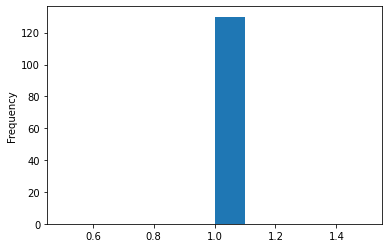

In [16]:
# Checking how many times subjects are appeared 
adcn3.Subject.value_counts().plot(kind = 'hist')
plt.show()

#### Part of the Dataframe without AD Dementia

In [17]:
# Create a new df without AD Dementia
df2 = df1[-df1['Subject'].isin(subject_list)]

# Keep only rows from dataframe with diagnose Cognitively normal
df2 = df2.loc[df2['dx1'] == 'Cognitively normal']

# Select ids that have had Normal Cognition
subject_list_2 = df2.loc[df2['dx1'] == 'Cognitively normal', 'Subject'].unique()

# Count the subjects who are Cognitively normal 
print('The subjects with normal cognition are {}.'.format(len(subject_list_2)))

# Keeping only these subjects who have at least two diagnoses
df2 = df2[df2['Subject'].isin(df2['Subject'].value_counts()[df2['Subject'].value_counts()>=2].index)]
subject_list_2_unique = df2.Subject.unique()
print('Subjects with at least two diagnoses are {}.\n'.format(len(df2.Subject.unique())))

# Print
df2.head()

The subjects with normal cognition are 715.
Subjects with at least two diagnoses are 646.



,Day,Subject,Gender,mmse,ageAtEntry,cdr,commun,dx1,dx2,dx3,...,BRNINJ,BRNINJIF,NEOP,NEOPIF,COGOTH,COGOTHIF,COGOTH2,COGOTH2F,COGOTH3,COGOTH3F
3091,0000,OAS30001,female,28.0,65.149895,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3581,0339,OAS30001,female,28.0,65.149895,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
5538,0722,OAS30001,female,30.0,65.149895,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
5943,1106,OAS30001,female,30.0,65.149895,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3324,1456,OAS30001,female,30.0,65.149895,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN


In [18]:
# Select random 130 unique subjects from the df2
rn = np.random.choice(subject_list_2_unique, 130, replace = False)

# Create a new dataframe with random subjects from df2
df3 = df2.loc[df2['Subject'].isin(rn)]

# For each Subject keep only two random diagnoses
size = 2        # sample size
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
df4 = df3.groupby('Subject', as_index=False, group_keys=False).apply(fn)
df4.sort_values(['Subject','Day'], inplace = True)
print('The lentgh of unique subjects are {}.\n'.format(len(df4.Subject.unique())))
df4.head()

The lentgh of unique subjects are 130.



,Day,Subject,Gender,mmse,ageAtEntry,cdr,commun,dx1,dx2,dx3,...,BRNINJ,BRNINJIF,NEOP,NEOPIF,COGOTH,COGOTHIF,COGOTH2,COGOTH2F,COGOTH3,COGOTH3F
6104,1083,OAS30003,female,30.0,58.773440,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2540,2630,OAS30003,female,29.0,58.773440,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
6211,0000,OAS30004,female,30.0,55.096508,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4791,1102,OAS30004,female,29.0,55.096508,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2734,0000,OAS30005,female,29.0,48.030117,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [19]:
# For each 'Subject' keep the first diagnoses
df4 = df4.groupby(['Subject'], as_index=False, group_keys=False).first()
df4.head()

,Subject,Day,Gender,mmse,ageAtEntry,cdr,commun,dx1,dx2,dx3,...,BRNINJ,BRNINJIF,NEOP,NEOPIF,COGOTH,COGOTHIF,COGOTH2,COGOTH2F,COGOTH3,COGOTH3F
0,OAS30003,1083,female,30.0,58.773440,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
1,OAS30004,0000,female,30.0,55.096508,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,OAS30005,0000,female,29.0,48.030117,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,OAS30007,0356,male,30.0,71.537300,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
4,OAS30011,1172,female,26.0,78.461330,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN


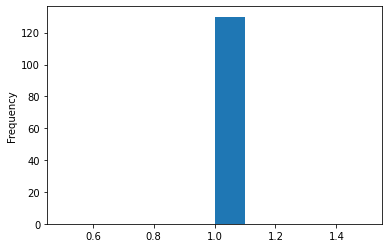

In [20]:
# Checking how many times subjects are appeared 
df4.Subject.value_counts().plot(kind = 'hist')
plt.show()

In [21]:
# Concatenate the dataframe tp and the dataframe df4
data = pd.concat([adcn3, df4])
#data.sort_index(inplace = True)
data = data.groupby('Subject').apply(lambda x:x.sort_values(['Day'],ascending = True)).reset_index(drop=True)
data.head(5)

,Day,Subject,Gender,mmse,ageAtEntry,cdr,commun,dx1,dx2,dx3,...,BRNINJ,BRNINJIF,NEOP,NEOPIF,COGOTH,COGOTHIF,COGOTH2,COGOTH2F,COGOTH3,COGOTH3F
0,1083,OAS30003,female,30.0,58.773440,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
1,0000,OAS30004,female,30.0,55.096508,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,0000,OAS30005,female,29.0,48.030117,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,0356,OAS30007,male,30.0,71.537300,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
4,1172,OAS30011,female,26.0,78.461330,0.0,0.0,Cognitively normal,.,.,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN


In [22]:
# Save the dataframe into a csv format
data.to_csv('data.csv', index = True)

# 2. PREPROCESSING

## ADRC CLINICAL DATA
#### Summary
* The cardinality of attribute 'Ethnicity' is 1. That means that we can remove it without affecting the result.  
* The range of values of attribute 'Education', is out of the known range of values.
* Attributes cdr and sumbox, have a strong correlation between them and also they offer the same information, so we can safely drop the attribute sumbox.  
* Regarding null values the following applies:
1) The height of subjects is not depended by other variables. So, if for a subject missing once, fill the missing value with the first one. If for a subject is missing in both cases, then we use the median value of the whole column.
2) The missing values of attribute apoe are very few. Missing values are on both cases of observation for rach subject. So, in this case we just use the mode value of the whole column. 
3) The mmmse is correlated with the attribute cdr, so it is safe to fill missing values on column mmmse based on the value of cdr. 
4) 

In [23]:
# Extract columns that correspong to ADRC Clinical Data 
adrc = data.loc[:, :'Ethnicity']
adrc.head()

,Day,Subject,Gender,mmse,ageAtEntry,cdr,commun,dx1,dx2,dx3,...,memory,orient,perscare,apoe,sumbox,height,weight,Education,Race,Ethnicity
0,1083,OAS30003,female,30.0,58.773440,0.0,0.0,Cognitively normal,.,.,...,0.0,0.0,0.0,33.0,0.0,65.0,164.0,16.0,Caucasian,Non-Hispanic
1,0000,OAS30004,female,30.0,55.096508,0.0,0.0,Cognitively normal,.,.,...,0.0,0.0,0.0,23.0,0.0,64.0,189.0,17.0,Caucasian,Non-Hispanic
2,0000,OAS30005,female,29.0,48.030117,0.0,0.0,Cognitively normal,.,.,...,0.0,0.0,0.0,33.0,0.0,62.0,168.0,16.0,Asian,Non-Hispanic
3,0356,OAS30007,male,30.0,71.537300,0.0,0.0,Cognitively normal,.,.,...,0.0,0.0,0.0,24.0,0.0,68.0,187.0,19.0,Caucasian,Non-Hispanic
4,1172,OAS30011,female,26.0,78.461330,0.0,0.0,Cognitively normal,.,.,...,0.0,0.0,0.0,33.0,0.0,61.0,170.0,12.0,African American,Non-Hispanic


In [24]:
# Have a view of the dataframe
print('The shape of the dataframe is {}.\n'.format(adrc.shape))

# Change the data type of column Day from object to int
adrc['Day'] = adrc['Day'].astype('int')

print('Data type of the columns')
print(adrc.dtypes)

The shape of the dataframe is (260, 24).

Data type of the columns
Day             int32
Subject        object
Gender         object
mmse          float64
ageAtEntry    float64
cdr           float64
commun        float64
dx1            object
dx2            object
dx3            object
dx4            object
dx5            object
homehobb      float64
judgment      float64
memory        float64
orient        float64
perscare      float64
apoe          float64
sumbox        float64
height        float64
weight        float64
Education     float64
Race           object
Ethnicity      object
dtype: object


In [25]:
# Determining cardinality in categorical variables
print('Cardinality of Categorical Variables')
print(adrc[['Gender','dx1','Race','Ethnicity']].nunique(),'\n')

# Checking if there is the same value in a column
print('Standar Deviation of Attributes')
print(adrc.describe().loc['std'])

Cardinality of Categorical Variables
Gender       2
dx1          2
Race         3
Ethnicity    2
dtype: int64 

Standar Deviation of Attributes
Day           1346.505621
mmse             1.539294
ageAtEntry       8.523289
cdr              0.062017
commun           0.069230
homehobb         0.092224
judgment         0.160225
memory           0.062017
orient           0.069230
perscare         0.000000
apoe             4.727692
sumbox           0.348530
height           3.855025
weight          35.584365
Education        2.673884
Name: std, dtype: float64


In [26]:
# Statistical analysis of columns of the dataframe
adrc.describe()

,Day,mmse,ageAtEntry,cdr,commun,homehobb,judgment,memory,orient,perscare,apoe,sumbox,height,weight,Education
count,260.000000,254.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.0,257.000000,260.000000,233.000000,254.000000,258.000000
mean,1158.269231,28.511811,69.982130,0.003846,0.005769,0.013462,0.048077,0.003846,0.005769,0.0,32.066148,0.076923,65.836910,169.562992,15.724806
std,1346.505621,1.539294,8.523289,0.062017,0.069230,0.092224,0.160225,0.062017,0.069230,0.0,4.727692,0.348530,3.855025,35.584365,2.673884
min,0.000000,23.000000,45.212868,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,22.000000,0.000000,53.000000,93.000000,8.000000
25%,0.000000,28.000000,65.533876,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,33.000000,0.000000,63.000000,144.250000,14.000000
50%,767.500000,29.000000,70.229980,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,33.000000,0.000000,66.000000,167.500000,16.000000
75%,1704.750000,30.000000,75.035591,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,34.000000,0.000000,69.000000,189.750000,18.000000
max,8827.000000,30.000000,88.490074,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,44.000000,5.000000,74.000000,326.000000,29.000000


In [27]:
# Missing Values
adrc.isnull().sum()

Day            0
Subject        0
Gender         0
mmse           6
ageAtEntry     0
cdr            0
commun         0
dx1            0
dx2            0
dx3            0
dx4            0
dx5            0
homehobb       0
judgment       0
memory         0
orient         0
perscare       0
apoe           3
sumbox         0
height        27
weight         6
Education      2
Race           0
Ethnicity      0
dtype: int64

In [28]:
# FILLING MISSING VALUES 
# Filling missing values of mmse, filling missing values by using the mode value of the column
adrc['mmse'].fillna(adrc['mmse'].mode()[0], inplace = True)

# Filling missing values of apoe, taking the mode value of apoe grouped by cdr
adrc['apoe'].fillna(adrc['apoe'].mode()[0], inplace = True)

# Filling missing values of height, using the height value if we have one one value for each subject, otherwise use the median of all height values  
adrc['height'] = adrc.groupby('Subject', as_index=False, group_keys=False).apply(lambda x:x['height'].fillna(method='bfill') if x['height'].isnull().iloc[0] else x['height'].fillna(method = 'ffill'))
adrc['height'].fillna(adrc['height'].median(),inplace=True)

# Filling missing values of weight, taking the median value of height grouped by mmse
adrc['weight'] = np.select([(adrc['weight'].isna() & adrc['mmse'].isin(list(range(24,31)))), 
                            (adrc['weight'].isna() & adrc['mmse'].isin(list(range(19,24)))),
                            (adrc['weight'].isna() & adrc['mmse'].isin(list(range(10,19)))),
                            (adrc['weight'].isna() & adrc['mmse'].isin(list(range(0,10))))],
                         [adrc[adrc['mmse'].isin(list(range(24,31)))]['weight'].median(),
                         adrc[adrc['mmse'].isin(list(range(19,24)))]['weight'].median(),
                         adrc[adrc['mmse'].isin(list(range(10,19)))]['weight'].median(),
                         adrc[adrc['mmse'].isin(list(range(0,10)))]['weight'].median()], default=adrc['weight'])

In [29]:
# Missing Values
adrc.isnull().sum()

Day           0
Subject       0
Gender        0
mmse          0
ageAtEntry    0
cdr           0
commun        0
dx1           0
dx2           0
dx3           0
dx4           0
dx5           0
homehobb      0
judgment      0
memory        0
orient        0
perscare      0
apoe          0
sumbox        0
height        0
weight        0
Education     2
Race          0
Ethnicity     0
dtype: int64

In [30]:
# Feature selection identifying correlation among attributes 
adrc.corr().style.background_gradient()

,Day,mmse,ageAtEntry,cdr,commun,homehobb,judgment,memory,orient,perscare,apoe,sumbox,height,weight,Education
Day,1.000000,-0.087231,-0.030398,0.010391,0.005409,0.029259,-0.001080,0.010391,-0.014679,nan,0.072715,0.007253,-0.057266,-0.183963,0.016165
mmse,-0.087231,1.000000,-0.305504,-0.224541,-0.229184,-0.147330,-0.208841,-0.224541,-0.192916,nan,-0.051230,-0.258791,-0.018060,0.128573,0.223961
ageAtEntry,-0.030398,-0.305504,1.000000,-0.012218,0.030464,0.024766,0.044414,-0.012218,-0.024883,nan,-0.051668,0.025906,-0.021316,-0.174025,-0.049736
cdr,0.010391,-0.224541,-0.012218,1.000000,0.894082,0.665970,0.369879,1.000000,0.894082,nan,0.012224,0.879394,0.002494,-0.083524,-0.063690
commun,0.005409,-0.229184,0.030464,0.894082,1.000000,0.592514,0.322974,0.894082,0.798606,nan,-0.042888,0.821621,0.010993,-0.105121,-0.033235
homehobb,0.029259,-0.147330,0.024766,0.665970,0.592514,1.000000,0.217324,0.665970,0.592514,nan,-0.011303,0.718408,-0.005604,-0.061949,-0.102754
judgment,-0.001080,-0.208841,0.044414,0.369879,0.322974,0.217324,1.000000,0.369879,0.322974,nan,0.030951,0.711346,0.002159,-0.067850,-0.171859
memory,0.010391,-0.224541,-0.012218,1.000000,0.894082,0.665970,0.369879,1.000000,0.894082,nan,0.012224,0.879394,0.002494,-0.083524,-0.063690
orient,-0.014679,-0.192916,-0.024883,0.894082,0.798606,0.592514,0.322974,0.894082,1.000000,nan,0.022357,0.821621,-0.011933,-0.069567,-0.096052
perscare,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [31]:
# Convert the values of column height from inches to cm
adrc['height'] = round(adrc["height"].apply(lambda x: 2.54*(x)))

# Convert the values of column weight from lbs to kg
adrc['weight'] = round(adrc["weight"].apply(lambda x: x/2.2))

# Create a new column calculating the body mass index (BMI)
adrc['BMI'] = round((adrc['weight']/(adrc['height']**2))*10000,2)

In [32]:
# Create a new column with the real age of each subject adding the columns Day and ageAtEntry
adrc['Age'] = ((adrc.ageAtEntry*365)+adrc.Day)/365

In [33]:
# Replace dot sign from columns dx2 to dx5 with 'No Diagnosis'
adrc['dx2'].replace('.','No Diagnosis', inplace = True)
adrc['dx3'].replace('.','No Diagnosis', inplace = True)
adrc['dx4'].replace('.','No Diagnosis', inplace = True)
adrc['dx5'].replace('.','No Diagnosis', inplace = True)

In [34]:
# Convert categorical variables 'Gender', 'dx1' and 'Race' into dummy variables 
adrc = pd.get_dummies(adrc, columns=['Gender'], drop_first=True)
adrc = pd.get_dummies(adrc, columns=['dx1','Race', 'dx2','dx3','dx4','dx5'], prefix='', prefix_sep='')

In [35]:
# Removing columns 
adrc.drop(['Ethnicity','Education','sumbox','height','weight','Day','ageAtEntry','Cognitively normal','No Diagnosis'], axis = 1, inplace=True)

# Drop duplicate columns
adrc = adrc.loc[:, ~adrc.columns.duplicated()]

In [36]:
# Rename column's name
# Gender: Male(1), Female(0)
# Cognititvely Normal (1)/ AD Dementia (0)
adrc.rename(columns={'Gender_male': 'Gender', 'AD Dementia': 'AD'}, inplace=True)

In [37]:
# Print 
adrc.head()

,Subject,mmse,cdr,commun,homehobb,judgment,memory,orient,perscare,apoe,...,Remote CVD,Remote Hypothyroidism,Remote Major Head Trauma,Remote Med-induced Cog Dys,Remote Mood disorder,Remote Other neurol/med diagnoses,Remote PD drug-induced,Active Bereavement,Active Med-induced Cog Dys,Remote Bereavement
0,OAS30003,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,...,0,0,0,0,0,0,0,0,0,0
1,OAS30004,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,...,0,0,0,0,0,0,0,0,0,0
2,OAS30005,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,...,0,0,0,0,0,0,0,0,0,0
3,OAS30007,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,...,0,0,0,0,0,0,0,0,0,0
4,OAS30011,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,...,0,0,0,0,0,0,0,0,0,0


### ADRC CLINICAL DATA - ANALYSIS

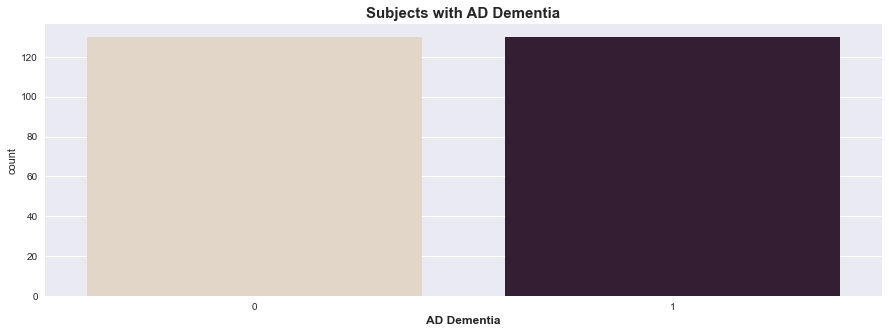


The percentage of subjects with AD Dementia is: 
0    50.0
1    50.0
Name: AD, dtype: float64.


In [38]:
# What is the percentage of subjects with AD Dementia
plt.style.use('seaborn')
plt.figure(figsize=(15,5))

sns.countplot(x="AD", data=adrc, palette="ch:.25")
plt.title('Subjects with AD Dementia',fontdict={'fontweight':'bold', 'fontsize':15})
plt.xlabel('AD Dementia', fontdict={'fontweight':'bold', 'fontsize':12})
plt.show()

print('\nThe percentage of subjects with AD Dementia is: \n{}.'.format(adrc.AD.value_counts(normalize=True)*100))

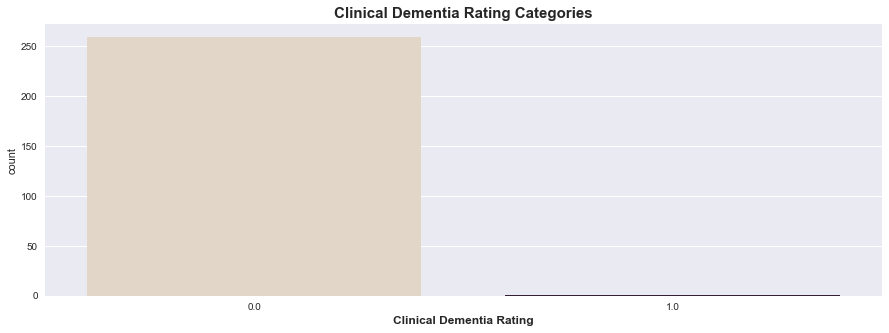


The percentage of frequencies of subjects for cdr value is: 
0.0    99.615385
1.0     0.384615
Name: cdr, dtype: float64

The number of subjects for cdr value is: 
0.0    259
1.0      1
Name: cdr, dtype: int64


In [39]:
# Calculating the frequencies of cdr
# Plotting frequencies of cdr
plt.figure(figsize = (15,5))
sns.countplot(x="cdr", data=adrc, palette="ch:.25")
plt.title('Clinical Dementia Rating Categories',fontdict={'fontweight':'bold', 'fontsize':15})
plt.xlabel('Clinical Dementia Rating', fontdict={'fontweight':'bold', 'fontsize':12})
plt.show()

print('\nThe percentage of frequencies of subjects for cdr value is: \n{}'.format(adrc.cdr.value_counts(normalize=True)*100))
print('\nThe number of subjects for cdr value is: \n{}'.format(adrc.cdr.value_counts(normalize=False)))

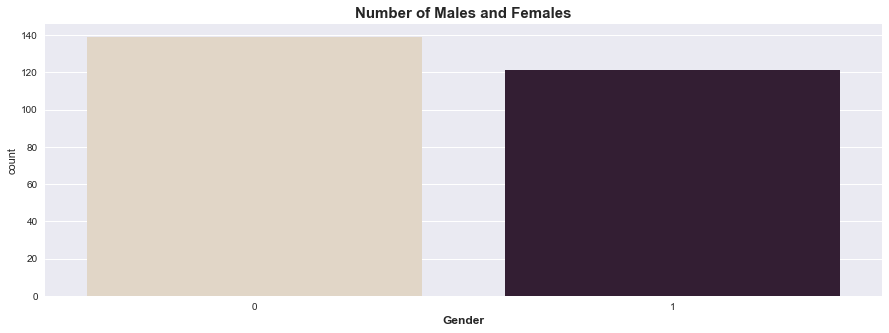


The percentage of males and females is: 
0    53.461538
1    46.538462
Name: Gender, dtype: float64


In [40]:
# Calculate the number of male and female subjects
# Male:1 / Female:0
plt.figure(figsize = (15,5))
sns.countplot(x="Gender", data=adrc, palette="ch:.25")
plt.title('Number of Males and Females',fontdict={'fontweight':'bold', 'fontsize':15})
plt.xlabel('Gender', fontdict={'fontweight':'bold', 'fontsize':12})
plt.show()

print('\nThe percentage of males and females is: \n{}'.format(adrc.Gender.value_counts(normalize=True)*100))

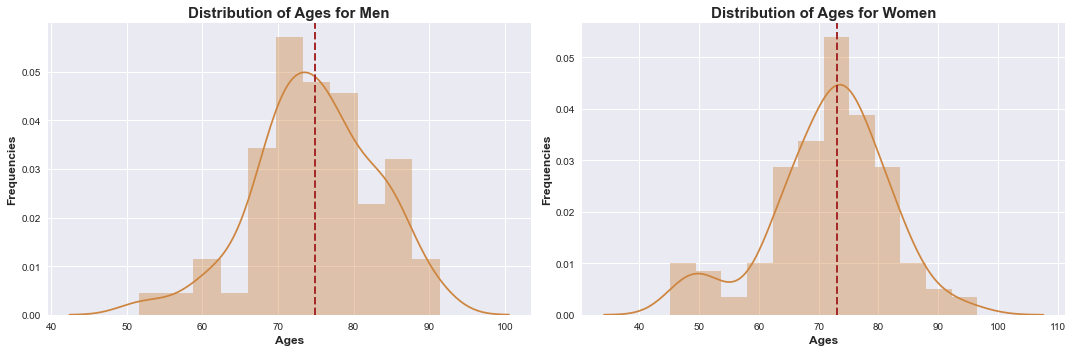

,min,max,median,mean
Gender,,,,
0,45.212868,96.497723,73.052648,71.641204
1,51.590123,91.384652,74.886415,74.894999


In [41]:
# Separate the dataframe for men and women
m = adrc[adrc.Gender == 1]
w = adrc[adrc.Gender == 0]

# Plotting the ages for men
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(m["Age"], hist=True, kde=True, rug=False, color = 'peru')
plt.xlabel('Ages', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Frequencies', fontdict={'fontweight':'bold', 'fontsize':12})
plt.title('Distribution of Ages for Men',fontdict={'fontweight':'bold', 'fontsize':15})
plt.axvline(m['Age'].median(), color='brown', linestyle='dashed', linewidth=2)
plt.tight_layout()

# Plotting the ages for women
plt.subplot(1,2,2)
sns.distplot(w["Age"], hist=True, kde=True, rug=False, color = 'peru')
plt.xlabel('Ages', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Frequencies', fontdict={'fontweight':'bold', 'fontsize':12})
plt.title('Distribution of Ages for Women',fontdict={'fontweight':'bold', 'fontsize':15})
plt.axvline(w['Age'].median(), color='brown', linestyle='dashed', linewidth=2)
plt.tight_layout()
plt.show()

# Printing statistics for ages of men and women 
adrc.groupby(['Gender'])['Age'].agg(['min','max','median','mean'])

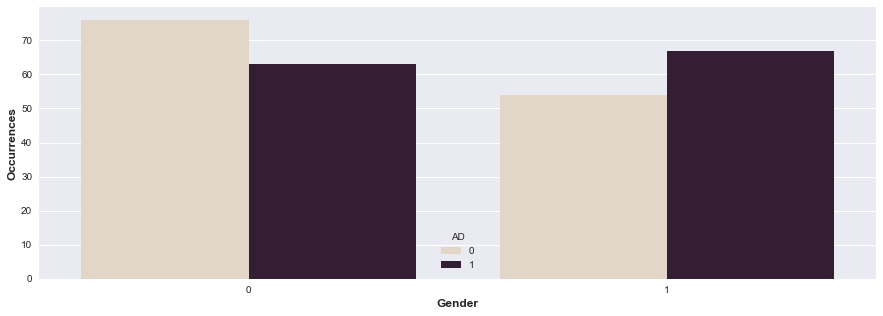

Gender    
Gender      0   1
AD               
0          76  54
1          63  67

In [42]:
# Calculate the number of males and females who have demantia
# AD yes:1 / AD no:0
plt.figure(figsize = (15,5))
sns.countplot(x = 'Gender', data = adrc, hue = 'AD', palette="ch:.25")
plt.xlabel('Gender', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Occurrences', fontdict={'fontweight':'bold', 'fontsize':12})
plt.show()

# Calculate the difference of cdr for females and males
a = pd.DataFrame(adrc.groupby(['AD'])['Gender'].value_counts())
a.unstack(level=-1)

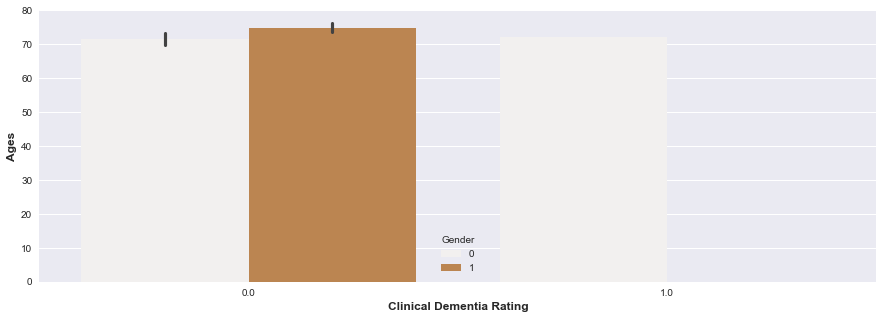

Age           
Gender          0          1
cdr                         
0.0     71.637891  74.894999
1.0     72.098421        NaN

In [43]:
# Plot the difference of cdr for females and males 
plt.figure(figsize = (15,5))
sns.barplot(y="Age", x='cdr', hue='Gender', color = 'peru', data = adrc)
plt.xlabel('Clinical Dementia Rating', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Ages', fontdict={'fontweight':'bold', 'fontsize':12})
plt.show()

# Calculate the difference of cdr for females and males
dfcdr = pd.DataFrame(adrc.groupby(['cdr','Gender'])['Age'].mean())
print('\n')
dfcdr.unstack(level=-1)

The age of participants in this survey are in range from 45 to 96.



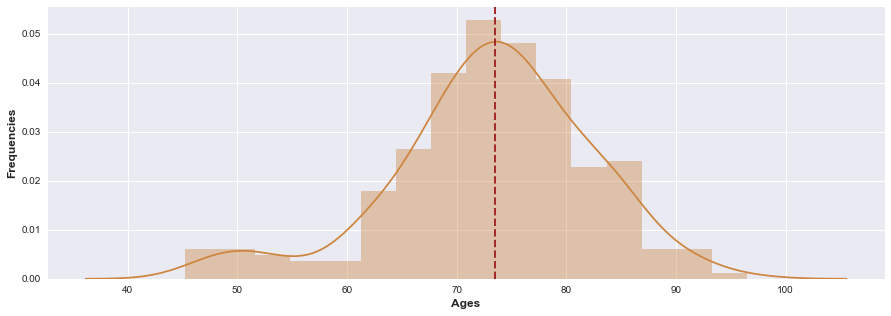

In [44]:
# Calculate the ages of participants
minage = adrc.Age.min()
maxage = adrc.Age.max()
print('The age of participants in this survey are in range from {} to {}.\n'.format(round(minage), round(maxage)))

plt.figure(figsize=(15,5))
sns.distplot(adrc["Age"], hist=True, kde=True, rug=False, color = 'peru')
plt.xlabel('Ages', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Frequencies', fontdict={'fontweight':'bold', 'fontsize':12})
plt.axvline(adrc['Age'].median(), color='brown', linestyle='dashed', linewidth=2)
plt.show()

In [45]:
# Separate the dataframe into two dataframe based on values of dementia
ad = adrc[adrc['AD'] == 1]
nonad = adrc[adrc['AD'] == 0]

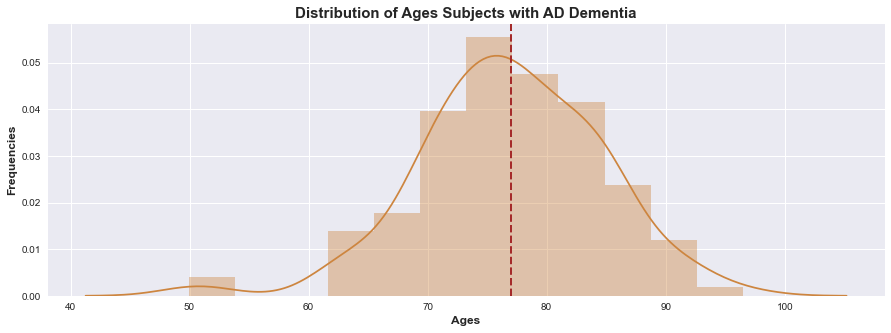

count    130.000000
mean      76.916686
std        7.673749
min       49.965780
25%       72.173923
50%       76.992837
75%       82.538663
max       96.497723
Name: Age, dtype: float64

In [46]:
# Calculate the ages of participants with AD demantia
plt.figure(figsize=(15,5))
sns.distplot(ad["Age"], hist=True, kde=True, rug=False, color = 'peru')
plt.xlabel('Ages', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Frequencies', fontdict={'fontweight':'bold', 'fontsize':12})
plt.title('Distribution of Ages Subjects with AD Dementia',fontdict={'fontweight':'bold', 'fontsize':15})
plt.axvline(ad['Age'].median(), color='brown', linestyle='dashed', linewidth=2)
plt.show()

ad['Age'].describe()

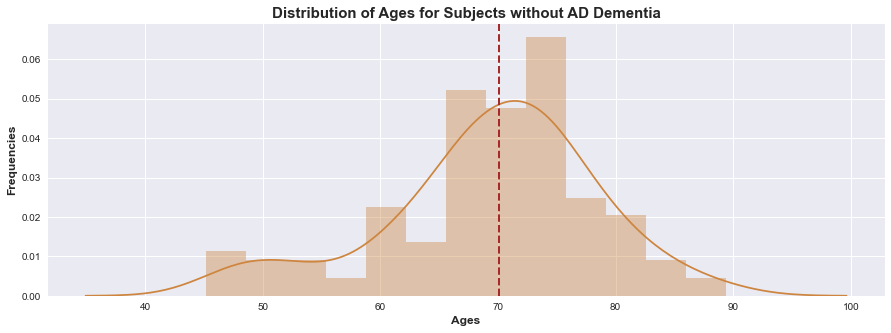

count    130.000000
mean      69.394255
std        9.052211
min       45.212868
25%       65.797930
50%       70.070504
75%       74.995269
max       89.377899
Name: Age, dtype: float64

In [47]:
# Calculate the ages of participants without AD demantia
plt.figure(figsize=(15,5))
sns.distplot(nonad["Age"], hist=True, kde=True, rug=False, color = 'peru')
plt.xlabel('Ages', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Frequencies', fontdict={'fontweight':'bold', 'fontsize':12})
plt.title('Distribution of Ages for Subjects without AD Dementia',fontdict={'fontweight':'bold', 'fontsize':15})
plt.axvline(nonad['Age'].median(), color='brown', linestyle='dashed', linewidth=2)
plt.show()

nonad['Age'].describe()

In [48]:
# Separate the dataframe into different dataframes based on values of cdr
cdr0 = adrc[adrc['cdr'] == 0]
cdr05 = adrc[adrc['cdr'] == 0.5]
cdr1 = adrc[adrc['cdr'] == 1]

,min,max,median
cdr,,,
0.0,45.212868,96.497723,73.520301
1.0,72.098421,72.098421,72.098421


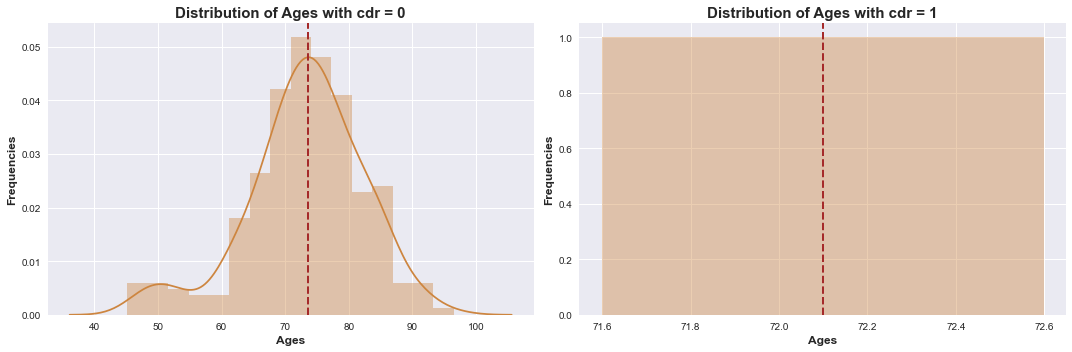

In [49]:
# Plotting the ages of participants with cdr = 0
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(cdr0["Age"], hist=True, kde=True, rug=False, color = 'peru')
plt.xlabel('Ages', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Frequencies', fontdict={'fontweight':'bold', 'fontsize':12})
plt.title('Distribution of Ages with cdr = 0',fontdict={'fontweight':'bold', 'fontsize':15})
plt.axvline(cdr0['Age'].median(), color='brown', linestyle='dashed', linewidth=2)
plt.tight_layout()


# Plotting the ages of participants with cdr = 1
plt.subplot(1,2,2)
sns.distplot(cdr1["Age"], hist=True, kde=True, rug=False, color = 'peru')
plt.xlabel('Ages', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Frequencies', fontdict={'fontweight':'bold', 'fontsize':12})
plt.title('Distribution of Ages with cdr = 1',fontdict={'fontweight':'bold', 'fontsize':15})
plt.axvline(cdr1['Age'].median(), color='brown', linestyle='dashed', linewidth=2)
plt.tight_layout()

# Calculate and print the min, max and median values of distributions for each cdr value
print('\n')
adrc.groupby(['cdr'])['Age'].agg(['min','max','median'])

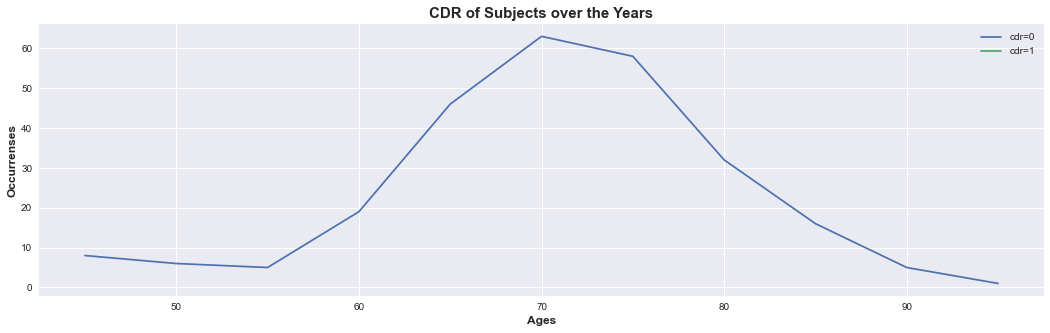


Number of Subjects with CDR over the years


cdr,0.0,1.0
Age,,
45.0,8.0,NaN
50.0,6.0,NaN
55.0,5.0,NaN
60.0,19.0,NaN
65.0,46.0,NaN
70.0,63.0,1.0
75.0,58.0,NaN
80.0,32.0,NaN
85.0,16.0,NaN


In [50]:
# Calculate the number of demented / non demented subjects divided by age 
cdrage = adrc.groupby([adrc.Age // 5 * 5, 'cdr']).size().unstack()

# Plot the number of demented / non demented subjects divided by age 
plt.figure(figsize=(18,5))
plt.plot(cdrage)
plt.legend(('cdr=0','cdr=1') ,loc="best")
plt.xlabel('Ages', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Occurrenses', fontdict={'fontweight':'bold', 'fontsize':12})
plt.title('CDR of Subjects over the Years',fontdict={'fontweight':'bold', 'fontsize':15})
plt.show()

# Print
print('\n''Number of Subjects with CDR over the years')
cdrage

In [51]:
# Create a new df from the dataframe adrc
adrc1 = adrc.copy()

In [52]:
# Create a new column with BMI Categories
adrc1.loc[adrc1.BMI < 18.5, 'BMI_cat'] = 'Underweight'
adrc1.loc[(adrc1.BMI > 18.5) & (adrc1.BMI <= 24.9), 'BMI_cat'] = 'Normal weight'
adrc1.loc[(adrc1.BMI > 25) & (adrc1.BMI <= 29.9), 'BMI_cat'] = 'Overweight'
adrc1.loc[adrc1.BMI > 30, 'BMI_cat'] = 'Obesity'

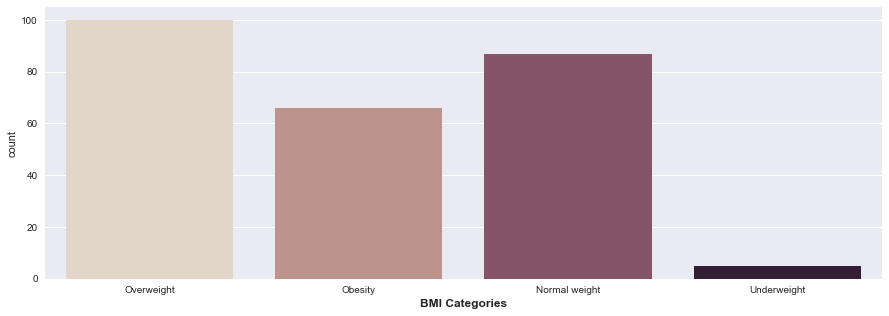


The percentage of Subjects on each BMI Category


Overweight       38.76
Normal weight    33.72
Obesity          25.58
Underweight       1.94
Name: BMI_cat, dtype: float64

In [53]:
# Calculate and plot the BMI Categories
plt.figure(figsize = (15,5))
sns.countplot(x="BMI_cat", data=adrc1, palette="ch:.25")
plt.xlabel('BMI Categories', fontdict={'fontweight':'bold', 'fontsize':12})
plt.show()

print('\nThe percentage of Subjects on each BMI Category')
round(adrc1.BMI_cat.value_counts(normalize=True)*100, 2)

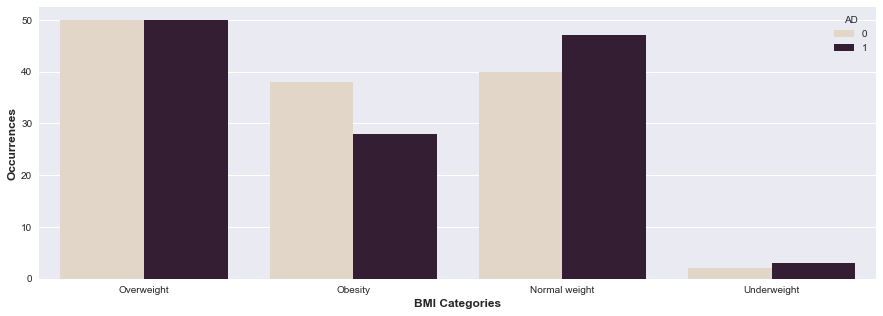

AD    
AD              0   1
BMI_cat              
Normal weight  40  47
Obesity        38  28
Overweight     50  50
Underweight     2   3

In [54]:
# Plot the number of demented / non demented subjects by BMI Category
plt.figure(figsize = (15,5))
sns.countplot(x = 'BMI_cat', hue = 'AD', data = adrc1, palette="ch:.25")
plt.xlabel('BMI Categories', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Occurrences', fontdict={'fontweight':'bold', 'fontsize':12})
plt.show()

# Calculate the number of demented / non demented subjects by BMI Category
b = pd.DataFrame(adrc1.groupby(['BMI_cat'])['AD'].value_counts())
print('\n')
b.unstack(level=-1)

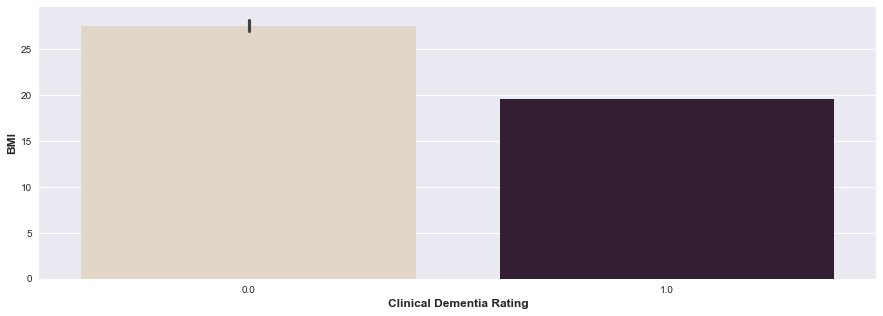

,BMI
cdr,
0.0,27.475097
1.0,19.490000


In [55]:
# Plot the relationship of weight with clinical dementia rating
plt.figure(figsize = (15,5))
sns.barplot(x='cdr', y='BMI', palette="ch:.25", data = adrc1)
plt.xlabel('Clinical Dementia Rating', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('BMI', fontdict={'fontweight':'bold', 'fontsize':12})
plt.show()

# We examine the relationship of height with clinical dementia rating
b = adrc1.groupby(['cdr'])['BMI'].mean()
b = pd.DataFrame(b)
print('\n')
b

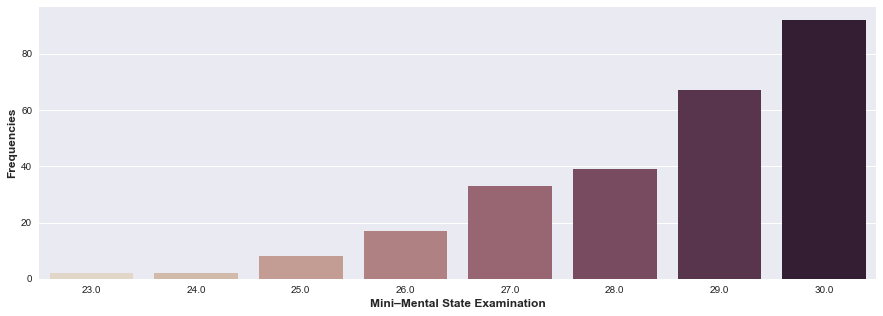



In the dataset there are: 
258(23.5%) normal cognition, 
2(0.18%) mild cognitive, 
0(0.0%) moderate cognitive and 
0(0.0%) severe cognitive impairment.


In [56]:
# Plotting the frequencies of mmse
plt.figure(figsize = (15,5))
sns.countplot('mmse', palette="ch:.25", data = adrc1)
plt.xlabel('Mini–Mental State Examination', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Frequencies', fontdict={'fontweight':'bold', 'fontsize':12})
plt.show()

# Calculate the frequency of individuals by their Mini-Mental State Examination. 
mmse = adrc1.mmse.value_counts().sort_index()

# Calculate the percentage of each segmentation
def perc(x):
    y = round(((x.sum())/1098)*100,2)
    return y

# Print the total amount of individuals on each type of cognitive statements
print('\n')
print('In the dataset there are: \n{}({}%) normal cognition, \n{}({}%) mild cognitive, \n{}({}%) moderate cognitive and \n{}({}%) severe cognitive impairment.'.format(mmse[24:30].sum(), perc(mmse[24:30]),
mmse[19:23].sum(), perc(mmse[19:23]), 
mmse[10:18].sum(), perc(mmse[10:18]),
mmse[:9].sum(), perc(mmse[:9])))

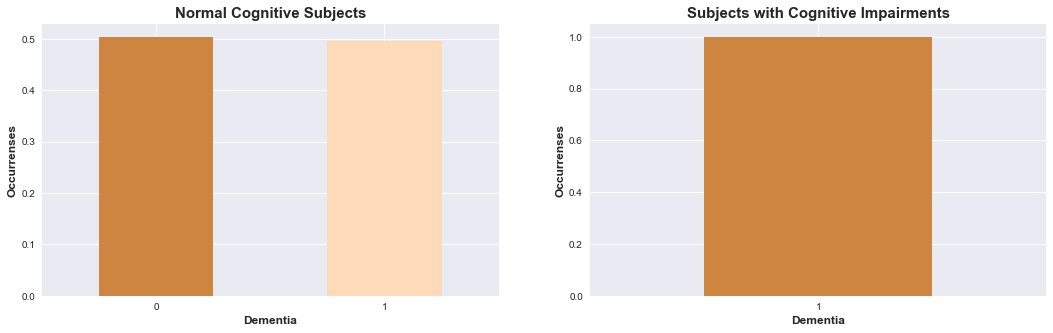


Normal Cognitive Subjects
 0    0.503876
1    0.496124
Name: AD, dtype: float64

Subjects with Cognitive Impairments
 1    1.0
Name: AD, dtype: float64


In [57]:
# From the dataframe examine the mmse column with dementia column 
normcog = adrc1[adrc1['mmse'] >= 24]['AD'].value_counts(normalize = True)
cogimp = adrc1[adrc1['mmse'] < 24]['AD'].value_counts(normalize = True)

normcog = normcog.sort_index()
cogimp = cogimp.sort_index()


# Plotting
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
normcog.plot(kind = 'bar', color = ['peru','peachpuff'])
plt.xticks(rotation = 0)
plt.xlabel('Dementia', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Occurrenses', fontdict={'fontweight':'bold', 'fontsize':12})
plt.title('Normal Cognitive Subjects',fontdict={'fontweight':'bold', 'fontsize':15})

plt.subplot(1,2,2)
cogimp.plot(kind = 'bar', color = ['peru','peachpuff'])
plt.xticks(rotation = 0)
plt.xlabel('Dementia', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Occurrenses', fontdict={'fontweight':'bold', 'fontsize':12})
plt.title('Subjects with Cognitive Impairments',fontdict={'fontweight':'bold', 'fontsize':15})
plt.show()

print('\nNormal Cognitive Subjects\n', normcog)
print('\nSubjects with Cognitive Impairments\n', cogimp)

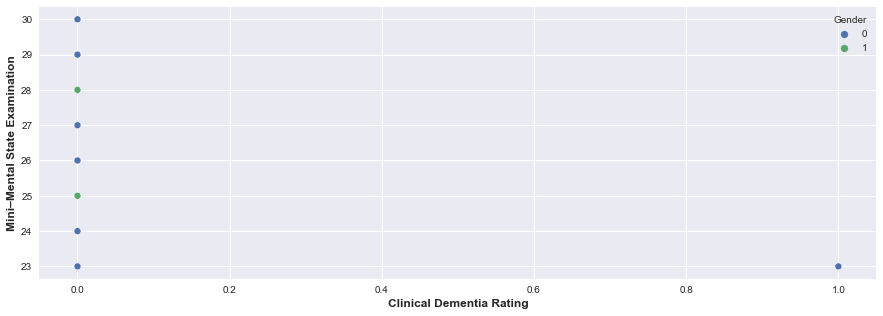

In [58]:
# Examine the relationship between cdr and mmse
plt.figure(figsize=(15,5))
sns.scatterplot(x='cdr',y='mmse',data=adrc1, hue='Gender')
plt.xlabel('Clinical Dementia Rating', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Mini–Mental State Examination', fontdict={'fontweight':'bold', 'fontsize':12})
plt.show()

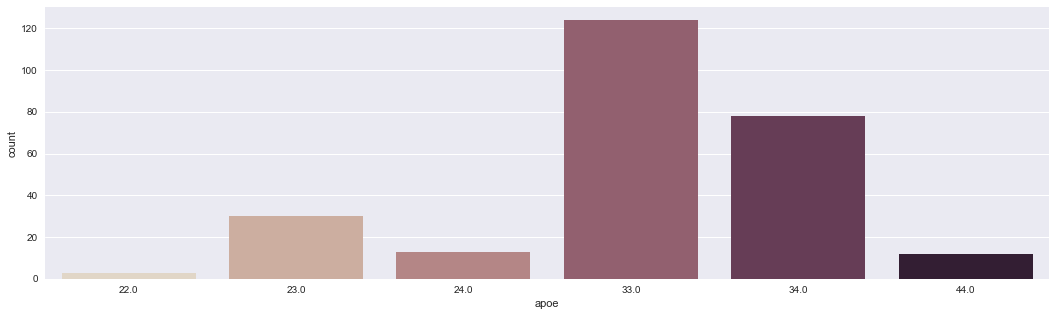

33.0    48.0
34.0    30.0
23.0    12.0
24.0     5.0
44.0     5.0
22.0     1.0
Name: apoe, dtype: float64

In [59]:
# Count the number of frequencies for each values of column apoe
plt.figure(figsize=(18,5))
sns.countplot(x = 'apoe', data = adrc1, palette="ch:.25")
plt.show()

print('\n')
round(adrc1.apoe.value_counts(normalize=True)*100)

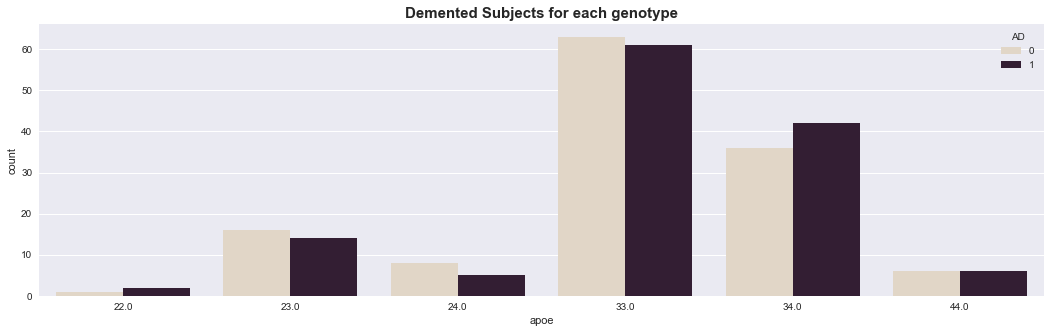

AD    
AD     0   1
apoe        
22.0   1   2
23.0  16  14
24.0   8   5
33.0  63  61
34.0  36  42
44.0   6   6

In [60]:
# Plotting demented subjects for each value of apoe genotype
plt.figure(figsize=(18,5))
sns.countplot(x = 'apoe', hue = 'AD', data = adrc1, palette="ch:.25")
plt.title('Demented Subjects for each genotype',fontdict={'fontweight':'bold', 'fontsize':15})
plt.show()

# Calculating demented subjects for each value of apoe genotype
c = pd.DataFrame(adrc1.groupby(['apoe'])['AD'].value_counts())
print('\n')
c.unstack(level=-1)

In [61]:
# Calculate the number of demented / non demented subjects divided by age 
d = adrc1.groupby([adrc1.Age // 5 * 5, 'AD']).size().unstack()
d

AD,0,1
Age,,
45.0,7.0,1.0
50.0,5.0,1.0
55.0,5.0,NaN
60.0,12.0,7.0
65.0,35.0,11.0
70.0,33.0,31.0
75.0,21.0,37.0
80.0,9.0,23.0
85.0,3.0,13.0


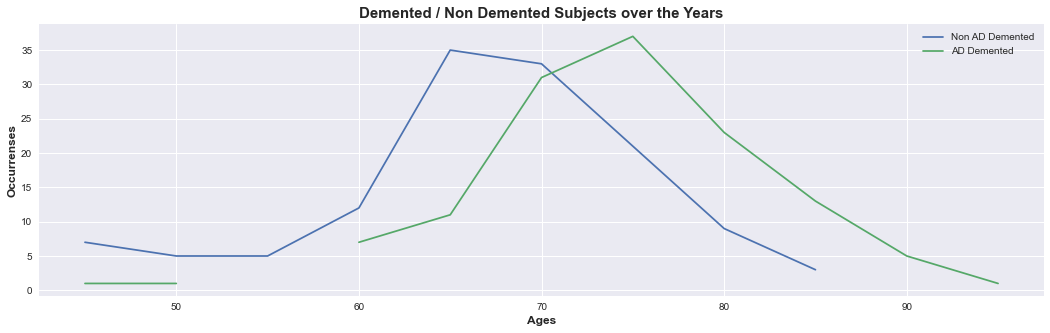

In [62]:
# Plot the number of demented / non demented subjects divided by age 
plt.figure(figsize=(18,5))
plt.plot(d)
plt.legend(('Non AD Demented','AD Demented') ,loc="best")
plt.xlabel('Ages', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Occurrenses', fontdict={'fontweight':'bold', 'fontsize':12})
plt.title('Demented / Non Demented Subjects over the Years',fontdict={'fontweight':'bold', 'fontsize':15})
plt.show()

## Form B5: Neuropsychiatric Inventory Questionnaire (NPI-Q)
#### Summary
* Each column is followed by another column that describes the severity of the illness. These columns have a huge number of null values and additionally, they are not connected correctly to each other. So all columns where at least 40% of total values are null values will be deleted. 
* The remaining columns have a small number of null values. We use the mode for each attribute to fill the null values. 

In [63]:
# Extract columns that correspong to the Form B5: Neuropsychiatric Inventory Questionnaire
npi = data[['Subject','NPIQINF','DEL','DELSEV','HALL','HALLSEV','AGIT','AGITSEV','DEPD','DEPDSEV','ANX','ANXSEV','ELAT','ELATSEV','APA','APASEV','DISN','DISNSEV','IRR','IRRSEV','MOT',
            'MOTSEV','NITE','NITESEV','APP','APPSEV']]
npi.head()

,Subject,NPIQINF,DEL,DELSEV,HALL,HALLSEV,AGIT,AGITSEV,DEPD,DEPDSEV,...,DISN,DISNSEV,IRR,IRRSEV,MOT,MOTSEV,NITE,NITESEV,APP,APPSEV
0,OAS30003,1.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
1,OAS30004,1.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
2,OAS30005,3.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
3,OAS30007,1.0,0.0,NaN,0.0,NaN,1.0,1.0,0.0,NaN,...,0.0,NaN,0.0,1.0,0.0,NaN,0.0,NaN,0.0,NaN
4,OAS30011,3.0,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN


In [64]:
# Have a view of the dataframe
print('The shape of the dataframe is {}.\n'.format(npi.shape))

print('Data type of the columns')
print(npi.dtypes)

The shape of the dataframe is (260, 26).

Data type of the columns
Subject     object
NPIQINF    float64
DEL        float64
DELSEV     float64
HALL       float64
HALLSEV    float64
AGIT       float64
AGITSEV    float64
DEPD       float64
DEPDSEV    float64
ANX        float64
ANXSEV     float64
ELAT       float64
ELATSEV    float64
APA        float64
APASEV     float64
DISN       float64
DISNSEV    float64
IRR        float64
IRRSEV     float64
MOT        float64
MOTSEV     float64
NITE       float64
NITESEV    float64
APP        float64
APPSEV     float64
dtype: object


In [65]:
# Missing Values
npi.isnull().sum()

Subject      0
NPIQINF     12
DEL         12
DELSEV     254
HALL        12
HALLSEV    259
AGIT        12
AGITSEV    221
DEPD        12
DEPDSEV    229
ANX         12
ANXSEV     242
ELAT        12
ELATSEV    255
APA         12
APASEV     237
DISN        12
DISNSEV    247
IRR         12
IRRSEV     208
MOT         12
MOTSEV     249
NITE        12
NITESEV    239
APP         12
APPSEV     229
dtype: int64

In [66]:
# DROP COLUMNS 
npi.dropna(thresh=len(npi)*.4, axis = 1, inplace = True) # where missing values is at least 40% of the whole column
npi.drop('NPIQINF', axis = 1, inplace = True) # NPI CO-PARTICIPANT, not needed for our work 

In [67]:
# Checking if there is the same value in a column
print('Standar Deviation of Attributes')
print(npi.describe().loc['std'])

Standar Deviation of Attributes
DEL     0.153960
HALL    0.063500
AGIT    0.352976
DEPD    0.312107
ANX     0.253196
ELAT    0.140836
APA     0.272840
DISN    0.223322
IRR     0.389476
MOT     0.197112
NITE    0.266514
APP     0.301681
Name: std, dtype: float64


In [68]:
# Filling missing values  
col_na = npi.columns[npi.isna().any()].tolist()
for column in col_na:
    npi[column].fillna(npi[column].mode()[0], inplace=True)

In [69]:
# Missing Values
npi.isnull().sum()

Subject    0
DEL        0
HALL       0
AGIT       0
DEPD       0
ANX        0
ELAT       0
APA        0
DISN       0
IRR        0
MOT        0
NITE       0
APP        0
dtype: int64

In [70]:
# Statistical analysis of columns of the dataframe
npi.describe()

,DEL,HALL,AGIT,DEPD,ANX,ELAT,APA,DISN,IRR,MOT,NITE,APP
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,0.023077,0.003846,0.138462,0.103846,0.065385,0.019231,0.076923,0.050000,0.176923,0.038462,0.073077,0.096154
std,0.150437,0.062017,0.346050,0.305649,0.247680,0.137600,0.266983,0.218365,0.382340,0.192679,0.260765,0.295371
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [71]:
# Have a look at the final dataframe
print('The shape of the final dataframe is {}.\n'.format(npi.shape))

The shape of the final dataframe is (260, 13).



## Form B6: Geriatric Depression Scale (GDS)
#### Summary
* The higher the value of GDS, the more severe the depression. 
* There are few missing values that we replace them using the attribute mmse. 

In [72]:
# Extract columns that correspong to the Form B5: Neuropsychiatric Inventory Questionnaire
gds = data[['Subject','GDS']]
gds.head()

,Subject,GDS
0,OAS30003,0.0
1,OAS30004,3.0
2,OAS30005,0.0
3,OAS30007,0.0
4,OAS30011,4.0


In [73]:
# Have a look at the dataframe
print('The shape of the dataframe is {}.\n'.format(gds.shape))

print('Data type of the columns')
print(gds.dtypes)

The shape of the dataframe is (260, 2).

Data type of the columns
Subject     object
GDS        float64
dtype: object


In [74]:
# Statistical analysis of columns of the dataframe
gds.describe()

,GDS
count,248.000000
mean,1.931452
std,5.857911
min,0.000000
25%,0.000000
50%,1.000000
75%,2.000000
max,88.000000


In [75]:
# Distribution of values
gds['GDS'].value_counts().sort_index()

0.0     89
1.0     71
2.0     35
3.0     19
4.0     12
5.0      9
6.0      1
7.0      3
8.0      3
9.0      2
10.0     2
11.0     1
88.0     1
Name: GDS, dtype: int64

In [76]:
# Missing Values
gds.isnull().sum()

Subject     0
GDS        12
dtype: int64

In [77]:
# FILLING MISSING VALUES 
# Filling missing values of GDS, taking the mode value of GDS column 
gds['GDS'].fillna(gds['GDS'].mode()[0], inplace = True)

# Replace the value 88: Did not complete, with the most frequent value of the column
gds['GDS'].replace(88,gds.GDS.mode()[0], inplace = True)

In [78]:
# Missing Values
gds.isnull().sum()

Subject    0
GDS        0
dtype: int64

In [79]:
# Distribution of values
gds['GDS'].value_counts().sort_index()

0.0     102
1.0      71
2.0      35
3.0      19
4.0      12
5.0       9
6.0       1
7.0       3
8.0       3
9.0       2
10.0      2
11.0      1
Name: GDS, dtype: int64

In [80]:
# Print the final dataframe
gds.head()

,Subject,GDS
0,OAS30003,0.0
1,OAS30004,3.0
2,OAS30005,0.0
3,OAS30007,0.0
4,OAS30011,4.0


## Form D1: Clinician Diagnosis
#### Summary
* The data frame which corresponds to the form d1, consists of attributes that are not included in the dictionary. Also, there are attributes where all values are null values and finally, there are values where the majority of the observations are null values. All these cases should be deleted. 
* There are attributes which are consist of the same value for all observations. These attributes will not contribute to the final prediction so we can delete them. 
* Due to the small percentage of null values, we can get the mode value for each attribute that has null values. 

In [81]:
# Create a new dataframe with attributes of D1: Clinical Diagnoses
cd = data[['Subject','WHODIDDX','NORMCOG','DEMENTED','MCIAMEM','MCIAPLUS','MCIAPLAN','MCIAPATT','MCIAPEX','MCIAPVIS','MCINON1','MCIN1LAN','MCIN1ATT','MCIN1EX','MCIN1VIS',
      'MCINON2','MCIN2LAN','MCIN2ATT','MCIN2EX','MCIN2VIS','IMPNOMCI','PROBAD','PROBADIF','POSSAD','POSSADIF','DLB','DLBIF','VASC','VASCIF','VASCPS','VASCPSIF','ALCDEM','ALCDEMIF',
      'DEMUN','DEMUNIF','FTD','FTDIF','PPAPH','PPAPHIF','PNAPH','SEMDEMAN','SEMDEMAG','PPAOTHR','PSP','PSPIF','CORT','CORTIF','HUNT','PRION','MEDS','MEDSIF','DYSILL','DYSILLIF','DEP',
      'DEPIF','OTHPSY','OTHPSYIF','DOWNS','DOWNSIF','PARK','PARKIF','STROKE','STROKIF','HYCEPH','HYCEPHIF','BRNINJ','BRNINJIF','NEOP','NEOPIF','COGOTH','COGOTHIF','COGOTH2','COGOTH2F',
      'COGOTH3','COGOTH3F']]
cd.head()

,Subject,WHODIDDX,NORMCOG,DEMENTED,MCIAMEM,MCIAPLUS,MCIAPLAN,MCIAPATT,MCIAPEX,MCIAPVIS,...,BRNINJ,BRNINJIF,NEOP,NEOPIF,COGOTH,COGOTHIF,COGOTH2,COGOTH2F,COGOTH3,COGOTH3F
0,OAS30003,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
1,OAS30004,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,OAS30005,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,OAS30007,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN
4,OAS30011,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN


In [82]:
# Check the initial shape of the dataframe 
print('The shape of the dataframe is: {}\n'.format(cd.shape))

The shape of the dataframe is: (260, 75)



In [83]:
cd.isnull().sum()

Subject       0
WHODIDDX     10
NORMCOG      10
DEMENTED    190
MCIAMEM     236
           ... 
COGOTHIF    259
COGOTH2      54
COGOTH2F    260
COGOTH3      54
COGOTH3F    260
Length: 75, dtype: int64

In [84]:
# DROP COLUMNS 
cd.drop(['WHODIDDX','PROBAD','PROBADIF','POSSAD','POSSADIF','DLB','DLBIF','VASC','VASCIF','VASCPS','VASCPSIF','DEMUN','DEMUNIF','FTD','FTDIF','PPAPH','PPAPHIF','PNAPH','SEMDEMAN','SEMDEMAG',
 'PPAOTHR','PARKIF','STROKIF'], axis = 1, inplace = True) # Drop columns that are not included in the dictionary

cd = delete(cd) # Drop columns where all values are null values

cd.dropna(thresh=len(cd)*.4, axis = 1, inplace = True) # where missing values is at least 40% of the whole column

In [85]:
# Check the shape of the dataframe after deleting columns 
print('The shape of the dataframe is: {}\n'.format(cd.shape))

print('DATA TYPE OF THE COLUMNS')
print(cd.dtypes)

The shape of the dataframe is: (260, 19)

DATA TYPE OF THE COLUMNS
Subject     object
NORMCOG    float64
PSP        float64
CORT       float64
HUNT       float64
PRION      float64
MEDS       float64
DYSILL     float64
DEP        float64
OTHPSY     float64
DOWNS      float64
PARK       float64
STROKE     float64
HYCEPH     float64
BRNINJ     float64
NEOP       float64
COGOTH     float64
COGOTH2    float64
COGOTH3    float64
dtype: object


In [86]:
# Checking if there is the same value in a column
a = cd.describe().loc['std']
b = (a[a==0].index).tolist()
if not b:
    print('There is no the same value in any of the columns of the dataframe.')
else:
    print('The attributes which they have the same value for all observation are:{}'.format(b))
    cd.drop(b, axis = 1, inplace = True)# Drop attributes from the dataframe which they have the same value for all observations

The attributes which they have the same value for all observation are:['PSP', 'CORT', 'HUNT', 'PRION', 'DOWNS', 'HYCEPH', 'NEOP', 'COGOTH2', 'COGOTH3']


In [87]:
# Statistical analysis of the attributes
cd.describe()

,NORMCOG,MEDS,DYSILL,DEP,OTHPSY,PARK,STROKE,BRNINJ,COGOTH
count,250.000000,250.000000,250.000000,250.000000,250.000000,245.000000,245.00000,250.000000,250.000000
mean,0.732000,0.012000,0.016000,0.220000,0.012000,0.016327,0.02449,0.012000,0.020000
std,0.443806,0.109104,0.125727,0.415077,0.109104,0.126987,0.15488,0.109104,0.140281
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [88]:
# Checking for missing values
cd.isnull().sum()

Subject     0
NORMCOG    10
MEDS       10
DYSILL     10
DEP        10
OTHPSY     10
PARK       15
STROKE     15
BRNINJ     10
COGOTH     10
dtype: int64

In [89]:
# Filling missing values by using the mode value for each column
cd_na = cd.columns[cd.isna().any()].tolist()
for column in cd_na:
    cd[column].fillna(cd[column].mode()[0], inplace=True)

In [90]:
# Checking for missing values
cd.isnull().sum()

Subject    0
NORMCOG    0
MEDS       0
DYSILL     0
DEP        0
OTHPSY     0
PARK       0
STROKE     0
BRNINJ     0
COGOTH     0
dtype: int64

In [91]:
# Final dataframe
cd.head()

,Subject,NORMCOG,MEDS,DYSILL,DEP,OTHPSY,PARK,STROKE,BRNINJ,COGOTH
0,OAS30003,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,OAS30004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,OAS30005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,OAS30007,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,OAS30011,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [92]:
cd.shape

(260, 10)

## Form B7: NACC Functional Assessment Scale (FAS)
#### Summary
* The number of null values for all columns in dataframe is very small so, it is used the mode value of each column to fill the null values. 

In [93]:
# Create a new dataframe with attributes of B7: Functional Assessment Scale (FAS)
fas = data[['Subject','BILLS','TAXES','SHOPPING','GAMES','STOVE','MEALPREP','EVENTS','PAYATTN','REMDATES','TRAVEL']]
fas.head()

,Subject,BILLS,TAXES,SHOPPING,GAMES,STOVE,MEALPREP,EVENTS,PAYATTN,REMDATES,TRAVEL
0,OAS30003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,OAS30004,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0
2,OAS30005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,OAS30007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,OAS30011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
# Check the initial shape of the dataframe 
print('The shape of the dataframe is: {}\n'.format(fas.shape))

print('DATA TYPE OF THE COLUMNS')
print(cd.dtypes)

The shape of the dataframe is: (260, 11)

DATA TYPE OF THE COLUMNS
Subject     object
NORMCOG    float64
MEDS       float64
DYSILL     float64
DEP        float64
OTHPSY     float64
PARK       float64
STROKE     float64
BRNINJ     float64
COGOTH     float64
dtype: object


In [95]:
# Checking if there is the same value in a column
a = fas.describe().loc['std']
b = (a[a==0].index).tolist()
if not b:
    print('There is no the same value in any of the columns of the dataframe.')
else:
    print('The attributes which they have the same value for all observation are:{}'.format(b))

There is no the same value in any of the columns of the dataframe.


In [96]:
# Statistical analysis of the attributes
fas.describe()

,BILLS,TAXES,SHOPPING,GAMES,STOVE,MEALPREP,EVENTS,PAYATTN,REMDATES,TRAVEL
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,0.984000,1.160000,0.464000,1.092000,0.156000,0.896000,0.148000,0.100000,0.276000,0.324000
std,2.416423,2.573888,1.623344,2.635016,0.924708,2.412564,0.650992,0.338316,0.776037,1.061854
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,2.000000,8.000000,8.000000


In [97]:
# Checking for missing values
fas.isnull().sum()

Subject      0
BILLS       10
TAXES       10
SHOPPING    10
GAMES       10
STOVE       10
MEALPREP    10
EVENTS      10
PAYATTN     10
REMDATES    10
TRAVEL      10
dtype: int64

In [98]:
# Filling missing values by using the mode value for each column
fas_na = fas.columns[fas.isna().any()].tolist()
for column in fas_na:
    fas[column].fillna(fas[column].mode()[0], inplace=True)

In [99]:
# Checking for missing values
fas.isnull().sum()

Subject     0
BILLS       0
TAXES       0
SHOPPING    0
GAMES       0
STOVE       0
MEALPREP    0
EVENTS      0
PAYATTN     0
REMDATES    0
TRAVEL      0
dtype: int64

In [100]:
# Final Dataframe
fas.head()

,Subject,BILLS,TAXES,SHOPPING,GAMES,STOVE,MEALPREP,EVENTS,PAYATTN,REMDATES,TRAVEL
0,OAS30003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,OAS30004,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0
2,OAS30005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,OAS30007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,OAS30011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
fas.shape

(260, 11)

## Form B9: Clinician Judgment of Symptoms
#### Summary
* The majority of the columns in the dataframe consist of columns whose most observations are null values. From the remaining columns, the range of values of attribute DECSUB is out of range. The attribute DECIN, is not important for the scope of our project. 

In [102]:
# Create a new dataframe with attributes of D1: Clinical Diagnoses
cj = data[['Subject','DECSUB','DECIN','DECAGE','COGMEM','COGJUDG','COGLANG','COGVIS','COGATTN','COGFLUC','COGOTHR','COGFRST','COGMODE','BEAPATHY','BEDEP','BEVHALL','BEVWELL',
           'BEAHALL','BEDEL','BEDISIN','BEIRRIT','BEAGIT','BEPERCH','BEREM','BEOTHR','BEFRST','BEMODE','MOGAIT','MOFALLS','MOTREM','MOSLOW','MOFRST','MOMODE','MOMOPARK','COURSE','FRSTCHG']]
cj.head()

,Subject,DECSUB,DECIN,DECAGE,COGMEM,COGJUDG,COGLANG,COGVIS,COGATTN,COGFLUC,...,BEMODE,MOGAIT,MOFALLS,MOTREM,MOSLOW,MOFRST,MOMODE,MOMOPARK,COURSE,FRSTCHG
0,OAS30003,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OAS30004,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OAS30005,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OAS30007,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OAS30011,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
# Check the initial shape of the dataframe 
print('The shape of the dataframe is: {}\n'.format(cj.shape))

print('DATA TYPE OF THE COLUMNS')
print(cj.dtypes)

The shape of the dataframe is: (260, 36)

DATA TYPE OF THE COLUMNS
Subject      object
DECSUB      float64
DECIN       float64
DECAGE      float64
COGMEM      float64
COGJUDG     float64
COGLANG     float64
COGVIS      float64
COGATTN     float64
COGFLUC     float64
COGOTHR     float64
COGFRST     float64
COGMODE     float64
BEAPATHY    float64
BEDEP       float64
BEVHALL     float64
BEVWELL     float64
BEAHALL     float64
BEDEL       float64
BEDISIN     float64
BEIRRIT     float64
BEAGIT      float64
BEPERCH     float64
BEREM       float64
BEOTHR      float64
BEFRST      float64
BEMODE      float64
MOGAIT      float64
MOFALLS     float64
MOTREM      float64
MOSLOW      float64
MOFRST      float64
MOMODE      float64
MOMOPARK    float64
COURSE      float64
FRSTCHG     float64
dtype: object


In [104]:
# Drop columns where the missing values consist of at least 40% of the whole column. 
cj.dropna(thresh=len(cj)*.4, axis = 1, inplace = True) # where missing values is at least 40% of the whole column

In [105]:
# Checking if there is the same value in a column
a = cj.describe().loc['std']
b = (a[a==0].index).tolist()
if not b:
    print('There is no the same value in any of the columns of the dataframe.')
else:
    print('The attributes which they have the same value for all observation are:{}'.format(b))

There is no the same value in any of the columns of the dataframe.


In [106]:
# Statistical analysis of the attributes
cj.describe()

,DECSUB,DECIN
count,242.000000,241.000000
mean,0.380165,0.377593
std,0.511384,0.485794
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,3.000000,1.000000


## Concatenate the Processed Dataframes
#### Summary
* We use concat, to concatenate the edited dataframes, and to add vertically the dataframes. 
* From the final dataframe, it seems that there is a very strong correlation between the target variable 'AD' and the variables 'cdr' and 'memory'. 
* For independent variables, the features 'cdr' and 'memory' have a very strong correlation between them, so we can keep only one of them. 

In [107]:
# From each dataframe, drop the column Subject 
npi1 = npi.drop(['Subject'], axis = 1)
gds1 = gds.drop(['Subject'], axis = 1)
cd1 = cd.drop(['Subject'], axis = 1)
fas1 = fas.drop(['Subject'], axis = 1)

In [108]:
# Concatenate dataframes
data1 = pd.concat([adrc, npi1, gds1, cd1, fas1], axis = 1)
data1.head()

,Subject,mmse,cdr,commun,homehobb,judgment,memory,orient,perscare,apoe,...,BILLS,TAXES,SHOPPING,GAMES,STOVE,MEALPREP,EVENTS,PAYATTN,REMDATES,TRAVEL
0,OAS30003,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,OAS30004,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,...,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0
2,OAS30005,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,OAS30007,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,OAS30011,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
# Checking for null values
data1.isnull().sum().any()

False

In [110]:
# Save the dataframe into a csv format
data1.to_csv('final_data.csv', index = True)

In [111]:
# Using Pearson Correlation 
cor = data1.corr()

# Correlation with output target
cor_target = cor['AD'].abs()

# Selecting highly correlated features 
relevant_features = cor_target[cor_target>0.3].sort_values(ascending = False)
relevant_features

AD          1.000000
NORMCOG     0.518843
Age         0.410334
mmse        0.325779
REMDATES    0.308179
Name: AD, dtype: float64

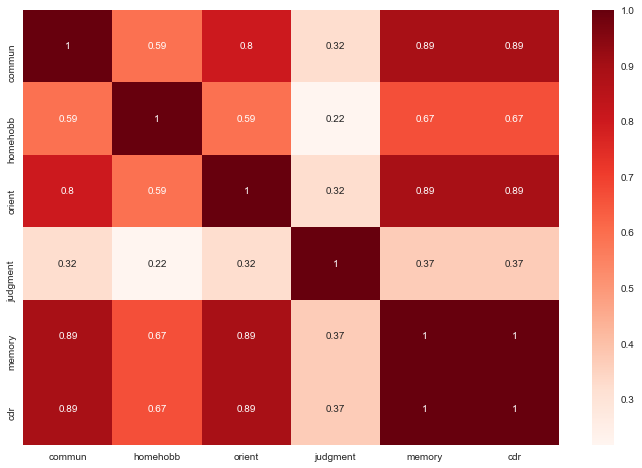

In [112]:
# Correlation among the independent variables, that have strong correation with the dependent variable AD
plt.figure(figsize=(12,8))
sns.heatmap(data1[['commun','homehobb','orient','judgment','memory','cdr']].corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

In [113]:
# Drop the attribute cdr 
#data1.drop(['cdr'], axis = 1, inplace = True)

# 3. Making Prediction Using Machine Learning Algorithms 
#### Summary
* Apart from classification accuracy of each model, we use are moving forward using different metrics. Apart from classification accuracy, we use and other techniques to evaluate the accuracy of the model such as confusion matrix, precision, recall, and F1 score.
* There is no big variance in classes of target attribute in testing set.

#### 1. Decision Trees

In [114]:
#split dataset in features and target variable
feature_cols = data1.drop(['Subject','AD','cdr'], axis = 1)
x = feature_cols
y = data1.AD

In [115]:
# Splitting data into training set and test set
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size = .3, random_state = 1)# 70% training set and 30% test set

In [116]:
# Create decision tree classifier object
clf = DecisionTreeClassifier(random_state=0)

# Train decision tree
clf = clf.fit(xtrain, ytrain)

# Predict the response for test dataset
y_pred = clf.predict(xtest)

# Evaluate model
print('Accuracy: %.2f%%' % metrics.accuracy_score(ytest, y_pred))

Accuracy: 0.74%


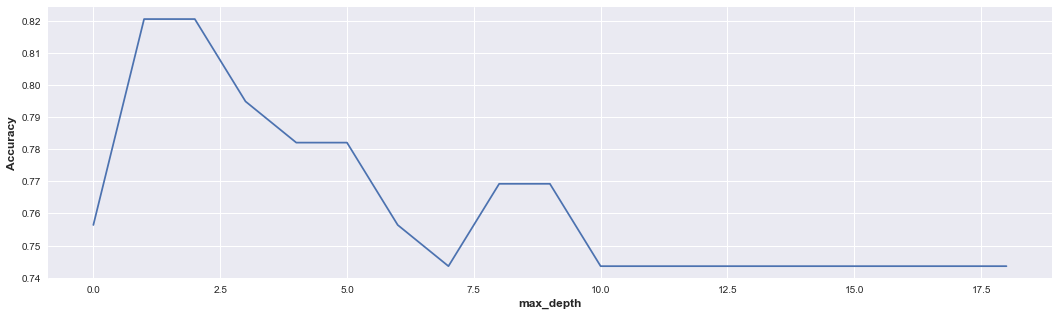

In [117]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 20))# List to store the average RMSE for each value of max_depth:
accuracy = []
for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth = depth, random_state = 0)
    clf.fit(xtrain, ytrain)    
    score = clf.score(xtest, ytest)
    accuracy.append(score)

# Plot the accuracy of the model
plt.figure(figsize=(18,5))
plt.plot(accuracy)
plt.xlabel('max_depth', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Accuracy', fontdict={'fontweight':'bold', 'fontsize':12})
plt.show()

In [118]:
# OPTIMIZING DECISION TREE PERFRORMANCE 
# Create a decision tree object
clf = DecisionTreeClassifier(random_state=0, max_depth=4)

# Train decision tree
clf = clf.fit(xtrain, ytrain)

# Predict the response for test data
y_pred = clf.predict(xtest)

# Predict probabilities for the test data
probs = clf.predict_proba(xtest)

# Keep Probabilities of the positive class only
probs = probs[:, 1]

# Evaluate model
print('Accuracy: %.2f%%' % metrics.accuracy_score(ytest, y_pred))

Accuracy: 0.79%


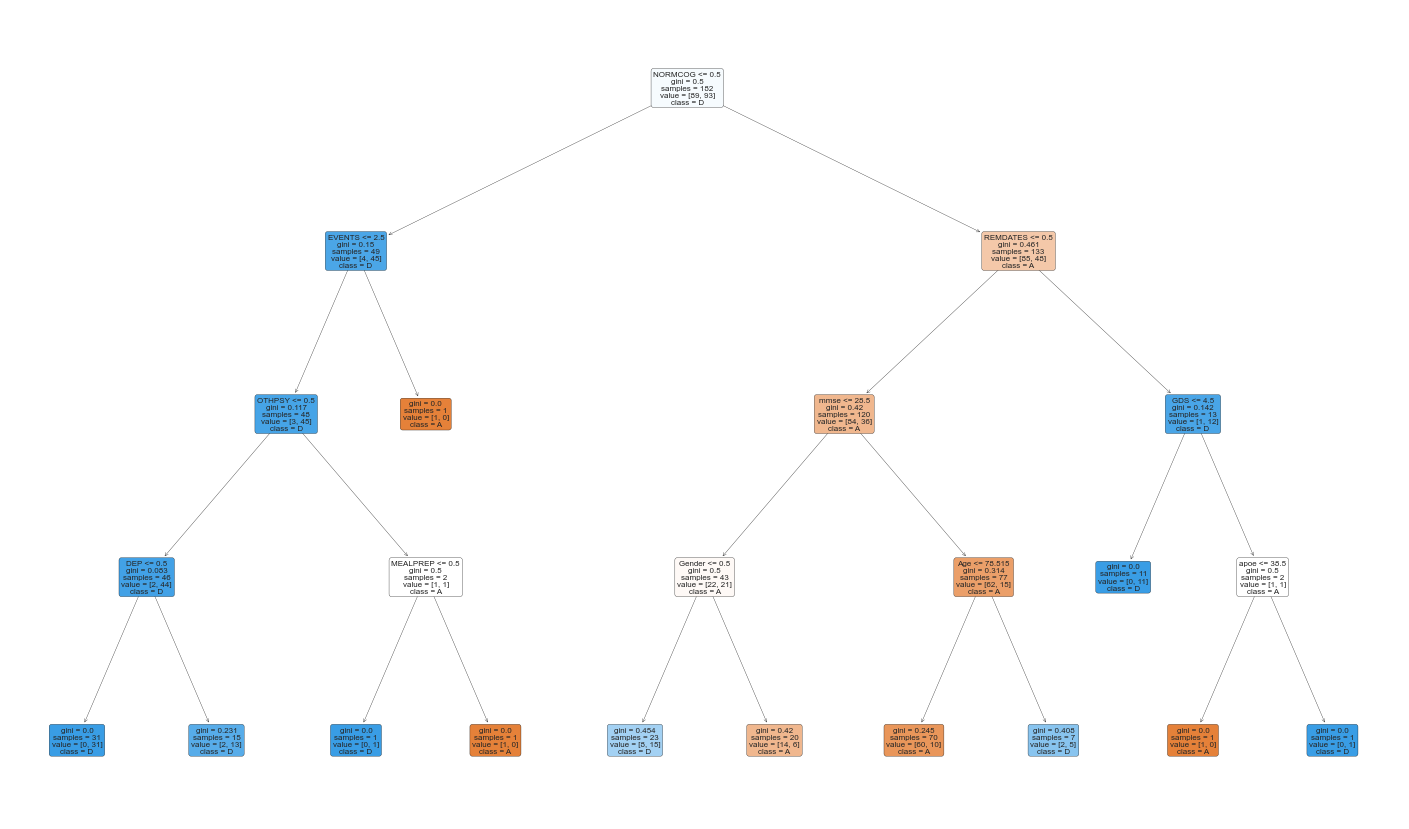

In [119]:
# Ploting Decision Tree
plt.figure(figsize=(25,15))
a = plot_tree(clf, 
              feature_names=x.columns, 
              class_names='AD', 
              filled=True, 
              rounded=True, 
              fontsize=8)

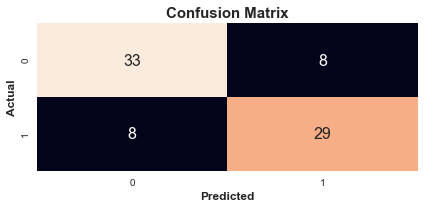


Precision Score: 0.7837837837837838

Sensitivity: 0.7837837837837838

Specificity: 0.8048780487804879

F1 Score: 0.7837837837837838


In [120]:
# Performance Metrics
# Confusion Matrix
plt.figure(figsize = (6,3))
cmdt = metrics.confusion_matrix(ytest, y_pred)
sns.heatmap(cmdt, annot=True, annot_kws={"size": 16}, fmt='', cbar = False)
plt.title('Confusion Matrix', fontdict={'fontweight':'bold', 'fontsize':15})
plt.xlabel('Predicted', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Actual', fontdict={'fontweight':'bold', 'fontsize':12})
plt.tight_layout()
plt.show()

# Precision 
print('\nPrecision Score:',metrics.precision_score(ytest, y_pred))# positive predictive value

# Recall / Sensitivity
print('\nSensitivity:', metrics.recall_score(ytest, y_pred))# true positive rate

# Specificity
print('\nSpecificity:', cmdt[0][0] / ((cmdt[0][0]) + (cmdt[0][1])))

# F1 Score
print('\nF1 Score:', metrics.f1_score(ytest, y_pred))

In [121]:
importances = pd.DataFrame({'feature':xtrain.columns,'importance':np.round(clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
importances.head(10)

,feature,importance
46,NORMCOG,0.457
63,REMDATES,0.187
0,mmse,0.098
9,Age,0.085
10,Gender,0.055
61,EVENTS,0.035
60,MEALPREP,0.021
7,apoe,0.021
45,GDS,0.017
50,OTHPSY,0.016


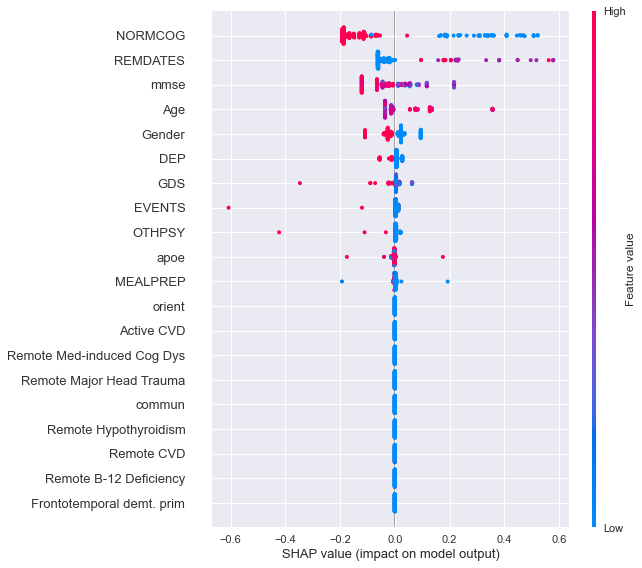

In [122]:
# explain the model's predictions using SHAP
shap_values = shap.TreeExplainer(clf).shap_values(xtrain)
shap.summary_plot(shap_values[1], xtrain)

In [123]:
# Defining a function to plot the ROC curves
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

AUC: 0.86


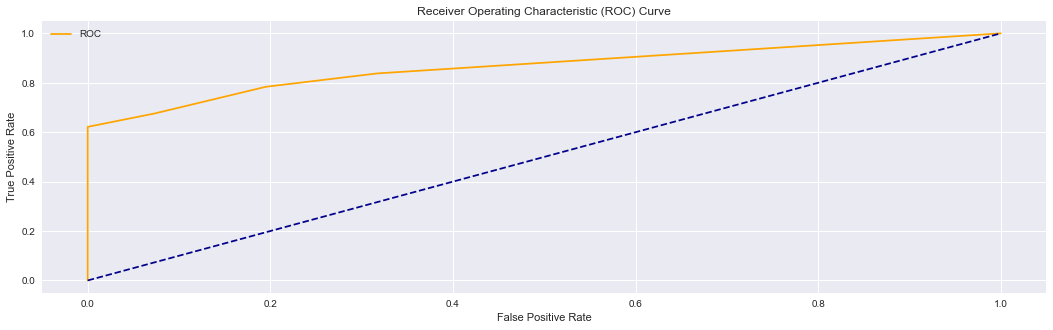

In [124]:
# Compute the AUC Score 
auc = metrics.roc_auc_score(ytest, probs)
print('AUC: %.2f' % auc)

# Get the ROC Curve
fpr, tpr, thresholds = metrics.roc_curve(ytest, probs)

# Plot ROC Curve using our defined function
plt.figure(figsize=(18,5))
plot_roc_curve(fpr, tpr)

#### 2. Random Forest

In [125]:
#split dataset in features and target variable
feature_cols = data1.drop(['Subject','AD','cdr'], axis = 1)
x = feature_cols
y = data1.AD

In [126]:
# Splitting the dataset into training set and test set
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size = .3, random_state = 4)# 70% training set and 30% test set

In [127]:
# Create a Gaussian classifiers
rclf = RandomForestClassifier(n_estimators=100, random_state=5)

# Train the model
rclf = rclf.fit(xtrain, ytrain)

# Make prediction
ypred = rclf.predict(xtest)

# Model Accuracy
print('Accuracy: %.2f%%' % metrics.accuracy_score(ytest, ypred))

Accuracy: 0.76%


In [161]:
# OPTIMIZING RANDOM FOREST ALGORITHM
# Create a Gaussian classifiers
rclf = RandomForestClassifier(random_state=5, n_estimators=100, max_features=20, min_samples_leaf=2)

# Train the model
rclf = rclf.fit(xtrain, ytrain)

# Make prediction
ypred = rclf.predict(xtest)

# Predict probabilities for the test data
probs = rclf.predict_proba(xtest)

# Keep Probabilities of the positive class only
probs = probs[:, 1]

# Model Accuracy
print('Accuracy: %.2f%%' % metrics.accuracy_score(ytest, ypred))

Accuracy: 0.82%


In [162]:
# Finding Important Features
feat_importances = pd.Series(rclf.feature_importances_, index=x.columns).sort_values(ascending=False)
feat_importances.head()

Age         0.172565
NORMCOG     0.162689
BMI         0.086191
mmse        0.078833
REMDATES    0.061067
dtype: float64

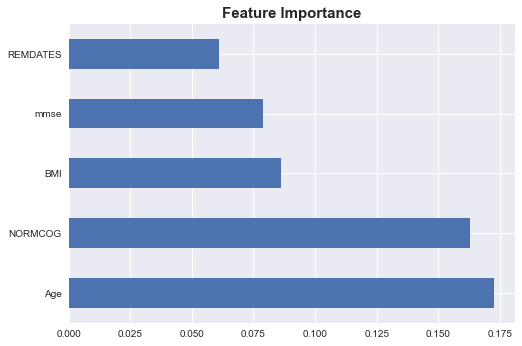

In [163]:
# Plot feature importance 
feat_importances.nlargest(5).plot(kind = 'barh')
plt.title('Feature Importance', fontdict={'fontweight':'bold', 'fontsize':15})
plt.show()

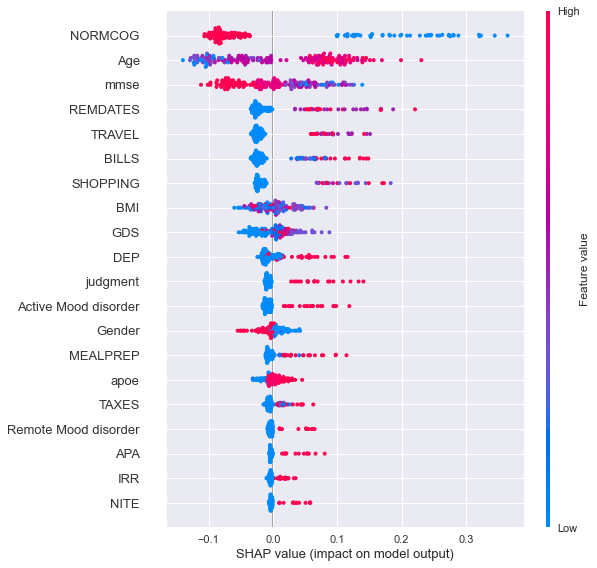

In [164]:
# explain the model's predictions using SHAP
shap_values = shap.TreeExplainer(rclf).shap_values(xtrain)
shap.summary_plot(shap_values[1], xtrain)

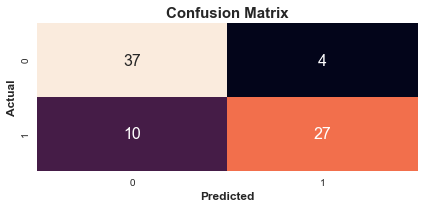


Precision Score: 0.8709677419354839

Sensitivity: 0.7297297297297297

Specificity: 0.9024390243902439

F1 Score: 0.7941176470588235


In [165]:
# Performance Metrics
# Confusion Matrix
plt.figure(figsize = (6,3))
cmrf = metrics.confusion_matrix(ytest, ypred)
sns.heatmap(cmrf, annot=True, annot_kws={"size": 16}, fmt='', cbar = False)
plt.title('Confusion Matrix', fontdict={'fontweight':'bold', 'fontsize':15})
plt.xlabel('Predicted', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Actual', fontdict={'fontweight':'bold', 'fontsize':12})
plt.tight_layout()
plt.show()

# Precision 
print('\nPrecision Score:',metrics.precision_score(ytest, ypred))# positive predictive value

# Recall / Sensitivity
print('\nSensitivity:', metrics.recall_score(ytest, ypred))# true positive rate

# Specificity
print('\nSpecificity:', cmrf[0][0] / ((cmrf[0][0]) + (cmrf[0][1])))

# F1 Score
print('\nF1 Score:', metrics.f1_score(ytest, ypred))

AUC: 0.93


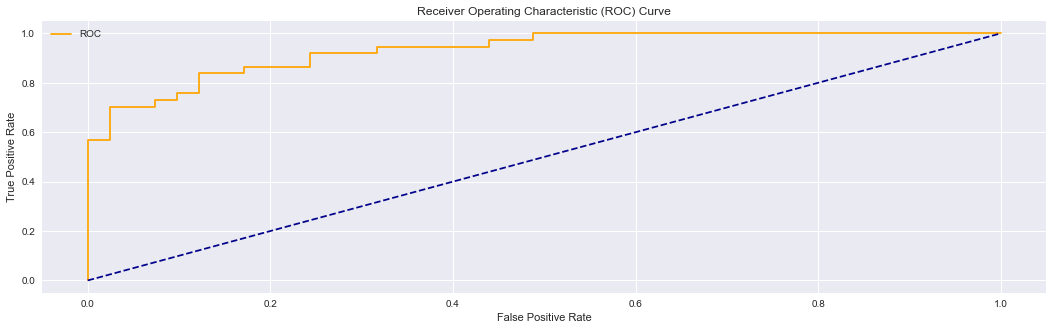

In [166]:
# Compute the AUC Score 
auc = metrics.roc_auc_score(ytest, probs)
print('AUC: %.2f' % auc)

# Get the ROC Curve
fpr, tpr, thresholds = metrics.roc_curve(ytest, probs)

# Plot ROC Curve using our defined function
plt.figure(figsize=(18,5))
plot_roc_curve(fpr, tpr)

#### 3. XGBOOST

In [134]:
#split dataset in features and target variable
feature_cols = data1.drop(['Subject','AD','cdr'], axis = 1)
x = feature_cols
y = data1.AD

In [135]:
# Splitting data into training set and test set
xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size = .3, random_state = 1)# 70% training set and 30% test set

print(f'PROPORTION OF TARGET IN THE ORIGINAL DATA\n{data1["AD"].value_counts() / len(data1)}\n\n'+
      f'PROPORTION OF TARGET IN THE TRAINING SET\n{ytrain.value_counts()/len(ytrain)}\n\n'+
      f'PROPORTION OF TARGET IN THE TEST SET\n{ytest.value_counts()/len(ytest)}')

PROPORTION OF TARGET IN THE ORIGINAL DATA
0    0.5
1    0.5
Name: AD, dtype: float64

PROPORTION OF TARGET IN THE TRAINING SET
1    0.510989
0    0.489011
Name: AD, dtype: float64

PROPORTION OF TARGET IN THE TEST SET
0    0.525641
1    0.474359
Name: AD, dtype: float64


In [136]:
# fit model no training data
xgb = XGBClassifier(eval_metric = "logloss", random_state=41)
xgb.fit(xtrain, ytrain)

# make predictions for test data
y_pred = xgb.predict(xtest)
predictions = [round(value) for value in y_pred]

# Predict probabilities for the test data
probs = xgb.predict_proba(xtest)

# Keep Probabilities of the positive class only
probs = probs[:, 1]

# evaluate predictions
accuracy = metrics.accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 76.92%


In [137]:
# OPTIMIZING XGBOOST ALGORITHM 
# fit model no training data
xgb = XGBClassifier(eval_metric = "logloss", learning_rate=.1, max_depth=10, gamma=0, random_state=41)
xgb.fit(xtrain, ytrain)

# make predictions for test data
y_pred = xgb.predict(xtest)
predictions = [round(value) for value in y_pred]

# Predict probabilities for the test data
probs = xgb.predict_proba(xtest)

# Keep Probabilities of the positive class only
probs = probs[:, 1]

# evaluate predictions
accuracy = metrics.accuracy_score(ytest, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 79.49%


In [138]:
# Finding Important Features
feat_importances = pd.Series(xgb.feature_importances_, index=x.columns).sort_values(ascending=False)
feat_importances.head(10)

NORMCOG                 0.231215
REMDATES                0.134143
SHOPPING                0.082523
Remote Mood disorder    0.069595
TRAVEL                  0.060004
Active Mood disorder    0.047220
BILLS                   0.035505
mmse                    0.032301
MEALPREP                0.029554
NITE                    0.026778
dtype: float32

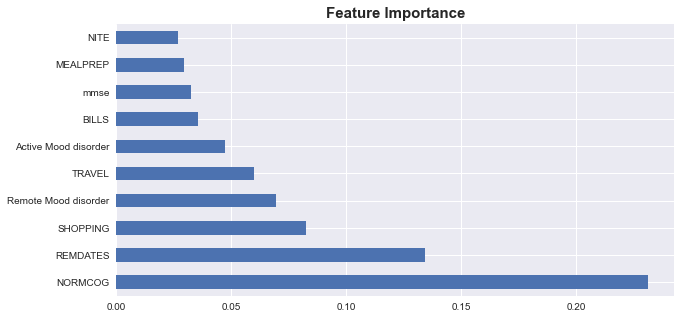

In [139]:
# Plot feature importance 
plt.figure(figsize=(10,5))
feat_importances.nlargest(10).plot(kind = 'barh')
plt.title('Feature Importance', fontdict={'fontweight':'bold', 'fontsize':15})
plt.show()

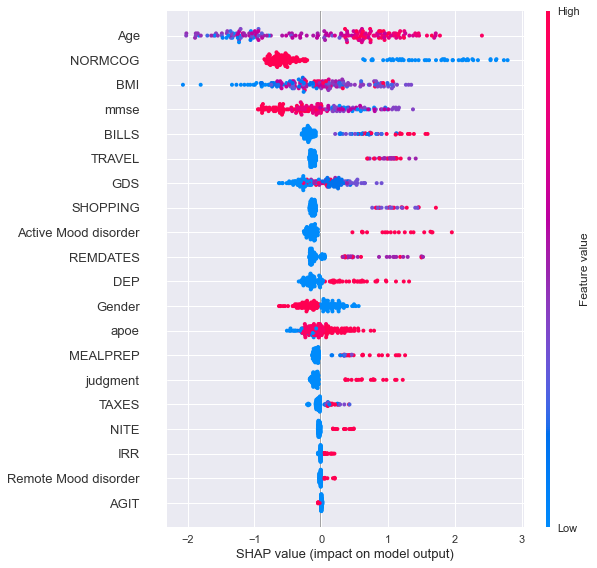

In [140]:
# explain the model's predictions using SHAP
shap_values = shap.TreeExplainer(xgb).shap_values(xtrain)
shap.summary_plot(shap_values, xtrain)

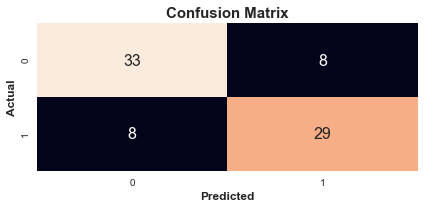


Precision Score: 0.7837837837837838

Sensitivity: 0.7837837837837838

Specificity: 0.8048780487804879

F1 Score: 0.7837837837837838


In [141]:
# Performance Metrics
# Confusion Matrix
plt.figure(figsize = (6,3))
cmxgb = metrics.confusion_matrix(ytest, y_pred)
sns.heatmap(cmxgb, annot=True, annot_kws={"size": 16}, fmt='', cbar = False)
plt.title('Confusion Matrix', fontdict={'fontweight':'bold', 'fontsize':15})
plt.xlabel('Predicted', fontdict={'fontweight':'bold', 'fontsize':12})
plt.ylabel('Actual', fontdict={'fontweight':'bold', 'fontsize':12})
plt.tight_layout()
plt.show()

# Precision 
print('\nPrecision Score:',metrics.precision_score(ytest, y_pred))# positive predictive value

# Recall / Sensitivity
print('\nSensitivity:', metrics.recall_score(ytest, y_pred))# true positive rate

# Specificity
print('\nSpecificity:', cmxgb[0][0] / ((cmxgb[0][0]) + (cmxgb[0][1])))

# F1 Score
print('\nF1 Score:', metrics.f1_score(ytest, y_pred))

AUC: 0.88


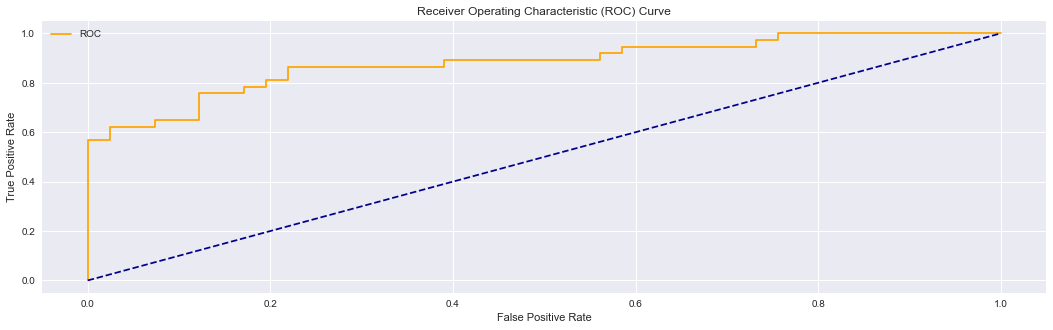

In [142]:
# Compute the AUC Score 
auc = metrics.roc_auc_score(ytest, probs)
print('AUC: %.2f' % auc)

# Get the ROC Curve
fpr, tpr, thresholds = metrics.roc_curve(ytest, probs)

# Plot ROC Curve using our defined function
plt.figure(figsize=(18,5))
plot_roc_curve(fpr, tpr)

##### Perform the training using KFolds cross validation method

In [143]:
# XGBoost
xgb = XGBClassifier(eval_metric = "logloss", learning_rate=.1, max_depth=5, gamma=0, random_state=41)
predicts_xgb = cross_val_predict(xgb,x,y,cv=10)
print('Accuracy:', cross_val_score(xgb, x, y, cv = 10, scoring='accuracy').mean())
print('Precision:', cross_val_score(xgb, x, y, cv = 10, scoring='precision').mean())
print('Sensitivity:', cross_val_score(xgb, x, y, cv = 10, scoring='recall').mean())
print('F1 Score:', cross_val_score(xgb, x, y, cv = 10, scoring='f1').mean())
print('Receiver Operating Characteristic (ROC):', cross_val_score(xgb, x, y, cv = 10, scoring='roc_auc').mean())
#print("Predicted class for each record: {}".format(predicts_xgb))
#print("Total records: {}, Total predicted values: {}".format(data1.shape[0],len(predicts_xgb)))

Accuracy: 0.7653846153846154
Precision: 0.796965256965257
Sensitivity: 0.7076923076923076
F1 Score: 0.745895679200027
Receiver Operating Characteristic (ROC): 0.8639053254437868


In [144]:
# Random Forest
rf = RandomForestClassifier(random_state=5, n_estimators=100, max_features=20, min_samples_leaf=2)
predicts_rf = cross_val_predict(rf,x,y,cv=10)
print('Accuracy:', cross_val_score(rf, x, y, cv = 10, scoring='accuracy').mean())
print('Precision:', cross_val_score(rf, x, y, cv = 10, scoring='precision').mean())
print('Sensitivity:', cross_val_score(rf, x, y, cv = 10, scoring='recall').mean())
print('F1 Score:', cross_val_score(rf, x, y, cv = 10, scoring='f1').mean())
print('Receiver Operating Characteristic (ROC):', cross_val_score(rf, x, y, cv = 10, scoring='roc_auc').mean())
#print("Predicted class for each record: {}".format(predicts_rf))
#print("Total records: {}, Total predicted values: {}".format(data1.shape[0],len(predicts_rf)))

Accuracy: 0.7884615384615385
Precision: 0.8455511155511155
Sensitivity: 0.7153846153846153
F1 Score: 0.7683991612252483
Receiver Operating Characteristic (ROC): 0.885207100591716


In [145]:
# Decision Tree
dt = DecisionTreeClassifier(max_depth=12)
predicts_dt = cross_val_predict(dt,x,y,cv=10)
print('Accuracy:', cross_val_score(dt, x, y, cv = 10, scoring='accuracy').mean())
print('Precision:', cross_val_score(dt, x, y, cv = 10, scoring='precision').mean())
print('Sensitivity:', cross_val_score(dt, x, y, cv = 10, scoring='recall').mean())
print('F1 Score:', cross_val_score(dt, x, y, cv = 10, scoring='f1').mean())
print('Receiver Operating Characteristic (ROC):', cross_val_score(dt, x, y, cv = 10, scoring='roc_auc').mean())
#print("Predicted class for each record: {}".format(predicts_dt))
#print("Total records: {}, Total predicted values: {}".format(data1.shape[0],len(predicts_dt)))

Accuracy: 0.6923076923076923
Precision: 0.6789611042552218
Sensitivity: 0.6692307692307693
F1 Score: 0.6756580086580087
Receiver Operating Characteristic (ROC): 0.6875739644970413


# 4. Using PyCaret Library to Make Prediction

In [146]:
# Create a new dataframe from data1
#data2 = data1.copy()

In [147]:
# Drop unnecessary attributes
#data2.drop(['Subject','cdr'], axis = 1, inplace=True)

In [148]:
#from pycaret.classification import *

In [149]:
#exp_clf101 = setup(data = data2, target = 'AD', session_id=123)

In [150]:
#best_model = compare_models()

In [151]:
#rf = create_model('rf')

In [152]:
#tuned_rf = tune_model(rf)

In [153]:
#plot_model(rf, plot = 'auc')

In [154]:
#plot_model(rf, plot = 'pr')

In [155]:
#plot_model(rf, plot = 'feature')

In [156]:
#plot_model(rf, plot = 'confusion_matrix')

In [157]:
#evaluate_model(rf)

In [158]:
#predict_model(rf)

In [159]:
#final_rf = finalize_model(rf)

In [160]:
#predict_model(final_rf)